In [2]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# New Antecedent/Consequent objects hold universe variables and membership
# functions
rmse = ctrl.Antecedent(np.arange(0, 1, 0.05), 'rmse')
sum_r = ctrl.Antecedent(np.arange(0, 1, 0.05), 'sum_r')
evaluation = ctrl.Consequent(np.arange(0, 1.25, 0.05), 'evaluation')

# Auto-membership function population is possible with .automf(3, 5, or 7)
rmse['very_low'] = fuzz.trimf(rmse.universe, [0, 0, 0.25])
rmse['low'] = fuzz.trimf(rmse.universe, [0, 0.25, 0.5])
rmse['medium'] = fuzz.trimf(rmse.universe, [0.25, 0.5, 0.75])
rmse['high'] = fuzz.trimf(rmse.universe, [0.5, 0.75, 1.0])
rmse['very_high'] = fuzz.trimf(rmse.universe, [0.75, 1.0, 1.0])

sum_r['very_low'] = fuzz.trimf(sum_r.universe, [0, 0, 0.25])
sum_r['low'] = fuzz.trimf(sum_r.universe, [0, 0.25, 0.5])
sum_r['medium'] = fuzz.trimf(sum_r.universe, [0.25, 0.5, 0.75])
sum_r['high'] = fuzz.trimf(sum_r.universe, [0.5, 0.75, 1.0])
sum_r['very_high'] = fuzz.trimf(sum_r.universe, [0.75, 1.0, 1.0])

# Custom membership functions can be built interactively with a familiar,
# Pythonic API
evaluation['very_low'] = fuzz.trimf(evaluation.universe, [0, 0, 0.25])
evaluation['low'] = fuzz.trimf(evaluation.universe, [0, 0.25, 0.5])
evaluation['medium'] = fuzz.trimf(evaluation.universe, [0.25, 0.5, 0.75])
evaluation['high'] = fuzz.trimf(evaluation.universe, [0.5, 0.75, 1.0])
evaluation['very_high'] = fuzz.trapmf(evaluation.universe, [0.75, 1.0, 1.25, 1.25])

In [4]:
#evaluation.view(sim=evaluator)

In [5]:
list_consequents = ['very_high','very_high','high','medium','low','very_high','high','medium','medium','low','high','medium','medium','low','very_low','medium','medium','low','very_low','very_low','low','low','very_low','very_low','very_low']

order_antecedent = ['very_low','low','medium','high','very_high'] 

list_rules = []
i = 0
for a1 in order_antecedent:
    for a2 in order_antecedent:
        list_rules.append(ctrl.Rule(rmse[a1] & sum_r[a2], evaluation[list_consequents[i]]))

        i += 1

In [6]:
fuzzy_aggregation = ctrl.ControlSystem(list_rules)

evaluator = ctrl.ControlSystemSimulation(fuzzy_aggregation)

In [7]:
evaluator.input['rmse'] = 0.0
evaluator.input['sum_r'] = 0.0

# Crunch the numbers
evaluator.compute()
evaluator.output['evaluation']

1.0294871794871796

In [8]:
evaluator.output['evaluation']

1.0294871794871796

In [9]:
R_VALUES = [10, 11, 12, 13, 15, 16, 18, 20, 22, 24, 27, 30, 33, 36, 39, 43, 47, 51, 56, 62, 68, 75, 82, 91]

In [10]:
len(R_VALUES)

24

## S and Z membership functions

In [11]:
Vref_s = np.concatenate((np.zeros(10), np.linspace(0,3,10), np.ones(10)*3))
Vref_z = np.concatenate((np.ones(10)*3, np.linspace(3,0,10), np.zeros(10)))

Vin = np.linspace(0,5,30)

In [18]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Real, Integer, Choice, Binary

class MixedVarsZDT1(ElementwiseProblem):

    def __init__(self, **kwargs):

        variables = dict()

        for k in range(4):
            variables[f'R_{k}'] = Integer(bounds=(0,23))
            variables[f'Rv_{k}'] = Integer(bounds=(2, 5))

        super().__init__(vars=variables, n_obj=2, **kwargs)

    def _evaluate(self, x, out, *args, **kwargs):

        R = [R_VALUES[x[f'R_{k}']]*10**(x[f'Rv_{k}']) for k in range(4)]
        
        Vout = -R[0]/R[3]*Vin + 3*(R[0]+R[3])*R[2]/(R[3]*(R[1]+R[2]))
        Vout[Vout>3] = 3
        Vout[Vout<0] = 0
        #print(Vout)

        rmse_val = np.sqrt(((Vout - Vref_z) ** 2).mean())
        sum_r_val = np.sum(R)/40000

        out["F"] = [rmse_val, sum_r_val]

In [19]:
from pymoo.visualization.scatter import Scatter
from pymoo.algorithms.moo.nsga2 import NSGA2, RankAndCrowdingSurvival
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.optimize import minimize

algorithm = NSGA2(pop_size=20,
                  sampling=MixedVariableSampling(),
                  mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                  eliminate_duplicates=MixedVariableDuplicateElimination(),
                  )

problem = MixedVarsZDT1()

res = minimize(problem,
               algorithm,
               ('n_gen', 200),
               seed=1,
               verbose=False)

{'R_0': 5, 'Rv_0': 5, 'R_1': 22, 'Rv_1': 4, 'R_2': 3, 'Rv_2': 2, 'R_3': 7, 'Rv_3': 3}
[1600000, 820000, 1300, 20000]
{'R_0': 11, 'Rv_0': 2, 'R_1': 1, 'Rv_1': 2, 'R_2': 7, 'Rv_2': 5, 'R_3': 13, 'Rv_3': 2}
[3000, 1100, 2000000, 3600]
{'R_0': 12, 'Rv_0': 4, 'R_1': 0, 'Rv_1': 2, 'R_2': 23, 'Rv_2': 5, 'R_3': 8, 'Rv_3': 4}
[330000, 1000, 9100000, 220000]
{'R_0': 8, 'Rv_0': 2, 'R_1': 17, 'Rv_1': 3, 'R_2': 4, 'Rv_2': 3, 'R_3': 11, 'Rv_3': 2}
[2200, 51000, 15000, 3000]
{'R_0': 9, 'Rv_0': 3, 'R_1': 8, 'Rv_1': 5, 'R_2': 5, 'Rv_2': 3, 'R_3': 12, 'Rv_3': 2}
[24000, 2200000, 16000, 3300]
{'R_0': 11, 'Rv_0': 4, 'R_1': 13, 'Rv_1': 3, 'R_2': 19, 'Rv_2': 3, 'R_3': 11, 'Rv_3': 2}
[300000, 36000, 62000, 3000]
{'R_0': 5, 'Rv_0': 4, 'R_1': 19, 'Rv_1': 4, 'R_2': 6, 'Rv_2': 5, 'R_3': 20, 'Rv_3': 2}
[160000, 620000, 1800000, 6800]
{'R_0': 15, 'Rv_0': 2, 'R_1': 15, 'Rv_1': 5, 'R_2': 8, 'Rv_2': 2, 'R_3': 4, 'Rv_3': 3}
[4300, 4300000, 2200, 15000]
{'R_0': 0, 'Rv_0': 5, 'R_1': 10, 'Rv_1': 2, 'R_2': 0, 'Rv_2': 2, '

C:\Users\tmedeiros\AppData\Local\Temp\ipykernel_18416\1173822155.py:23: RuntimeWarning: overflow encountered in long_scalars
  Vout = -R[0]/R[3]*Vin + 3*(R[0]+R[3])*R[2]/(R[3]*(R[1]+R[2]))


{'R_0': 6, 'Rv_0': 2, 'R_1': 0, 'Rv_1': 2, 'R_2': 10, 'Rv_2': 2, 'R_3': 0, 'Rv_3': 2}
[1800, 1000, 2700, 1000]
{'R_0': 5, 'Rv_0': 2, 'R_1': 0, 'Rv_1': 2, 'R_2': 10, 'Rv_2': 2, 'R_3': 10, 'Rv_3': 2}
[1600, 1000, 2700, 2700]
{'R_0': 0, 'Rv_0': 2, 'R_1': 0, 'Rv_1': 2, 'R_2': 2, 'Rv_2': 2, 'R_3': 10, 'Rv_3': 2}
[1000, 1000, 1200, 2700]
{'R_0': 2, 'Rv_0': 2, 'R_1': 0, 'Rv_1': 2, 'R_2': 6, 'Rv_2': 2, 'R_3': 0, 'Rv_3': 2}
[1200, 1000, 1800, 1000]
{'R_0': 0, 'Rv_0': 2, 'R_1': 0, 'Rv_1': 2, 'R_2': 8, 'Rv_2': 2, 'R_3': 0, 'Rv_3': 2}
[1000, 1000, 2200, 1000]
{'R_0': 3, 'Rv_0': 2, 'R_1': 1, 'Rv_1': 2, 'R_2': 8, 'Rv_2': 2, 'R_3': 0, 'Rv_3': 2}
[1300, 1100, 2200, 1000]
{'R_0': 18, 'Rv_0': 2, 'R_1': 0, 'Rv_1': 2, 'R_2': 9, 'Rv_2': 2, 'R_3': 0, 'Rv_3': 2}
[5600, 1000, 2400, 1000]
{'R_0': 17, 'Rv_0': 2, 'R_1': 1, 'Rv_1': 2, 'R_2': 10, 'Rv_2': 2, 'R_3': 0, 'Rv_3': 2}
[5100, 1100, 2700, 1000]
{'R_0': 4, 'Rv_0': 2, 'R_1': 0, 'Rv_1': 2, 'R_2': 4, 'Rv_2': 2, 'R_3': 0, 'Rv_3': 2}
[1500, 1000, 1500, 1000]
{'R

In [284]:
def z_FP(X):
    X = X.astype('int')
    R = [R_VALUES[X[i]]*10**(X[i+1]) for i in range(0, X.shape[0], 2)]
    
    Vout = -R[0]/R[3]*Vin + 3*(R[0]+R[3])*R[2]/(R[3]*(R[1]+R[2]))
    Vout[Vout>3] = 3
    Vout[Vout<0] = 0

    rmse_val = np.sqrt(((Vout - Vref_z) ** 2).mean())
    sum_r_val = np.sum(R)/40000

    
    evaluator.input['rmse'] = rmse_val
    evaluator.input['sum_r'] = sum_r_val

    evaluator.compute()
    
    return -evaluator.output['evaluation']


def z_FP_MO(X):
    X = X.astype('int')
    R = [R_VALUES[X[i]]*10**(X[i+1]) for i in range(0, X.shape[0], 2)]
    
    Vout = -R[0]/R[3]*Vin + 3*(R[0]+R[3])*R[2]/(R[3]*(R[1]+R[2]))
    Vout[Vout>3] = 3
    Vout[Vout<0] = 0

    rmse_val = np.sqrt(((Vout - Vref_z) ** 2).mean())
    sum_r_val = np.sum(R)/40000
    
    res = 1 - (0.5*rmse_val + 0.5*sum_r_val)

    return -res



In [285]:
def s_FP(X):
    X = X.astype('int')
    R = [R_VALUES[X[i]]*10**(X[i+1]) for i in range(0, X.shape[0], 2)]
    
    Vout = (1 + R[0]/R[1] + R[1]/R[2])*Vin - 3*R[0]/R[1]
    Vout[Vout>3] = 3
    Vout[Vout<0] = 0

    rmse_val = np.sqrt(((Vout - Vref_s) ** 2).mean())
    sum_r_val = np.sum(R)/30000

    
    evaluator.input['rmse'] = rmse_val
    evaluator.input['sum_r'] = sum_r_val

    evaluator.compute()
    
    return -evaluator.output['evaluation']

def s_FP_MO(X):
    X = X.astype('int')
    R = [R_VALUES[X[i]]*10**(X[i+1]) for i in range(0, X.shape[0], 2)]
    
    Vout = (1 + R[0]/R[1] + R[1]/R[2])*Vin - 3*R[0]/R[1]
    Vout[Vout>3] = 3
    Vout[Vout<0] = 0

    rmse_val = np.sqrt(((Vout - Vref_s) ** 2).mean())
    sum_r_val = np.sum(R)/30000
    
    res = 1 - (0.5*rmse_val + 0.5*sum_r_val)

    return -res



|||_______________________________________________ 6.2% GA is running...

C:\Users\tmedeiros\AppData\Local\Temp\ipykernel_19896\2942314074.py:5: RuntimeWarning: overflow encountered in long_scalars
  Vout = -R[0]/R[3]*Vin + 3*(R[0]+R[3])*R[2]/(R[3]*(R[1]+R[2]))


 The best solution found:                                                                           
 [ 8.  2.  9.  2. 19.  2.  1.  2.]

 Objective function:
 -0.9406827695600066


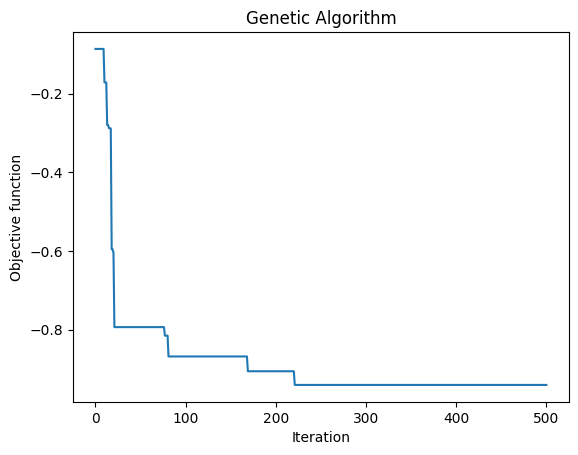

 The best solution found:                                                                           
 [14.  2.  3.  2. 12.  2.  7.  2.]

 Objective function:
 -0.9861682420401068


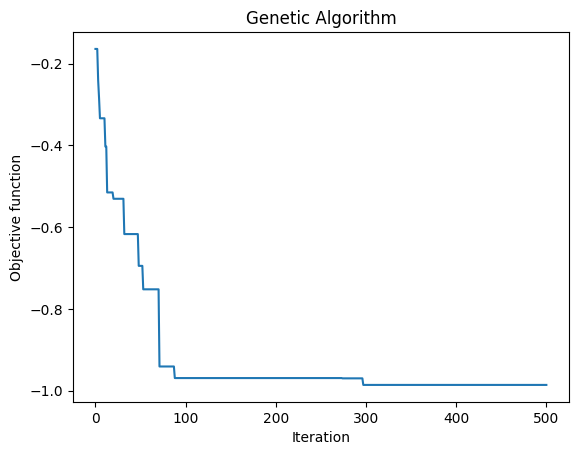

 The best solution found:                                                                           
 [ 9.  2.  6.  2. 16.  2.  2.  2.]

 Objective function:
 -1.004285811025872


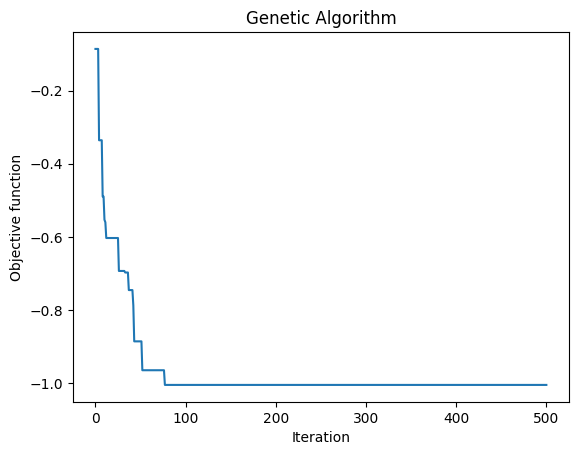

 The best solution found:                                                                           
 [13.  2.  1.  2. 10.  2.  7.  2.]

 Objective function:
 -0.9732427662347837


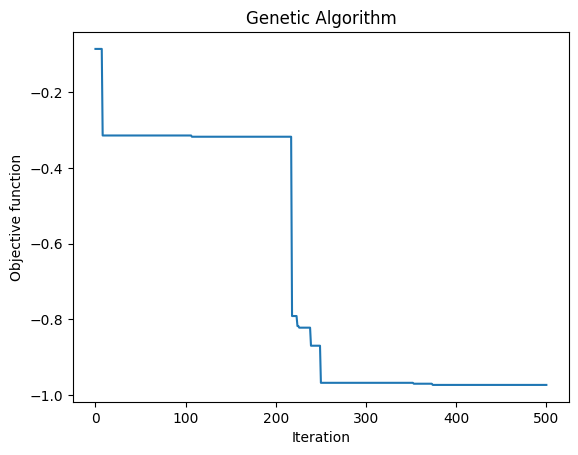

 The best solution found:                                                                           
 [14.  2.  2.  2. 11.  2.  7.  2.]

 Objective function:
 -0.9849674523605174


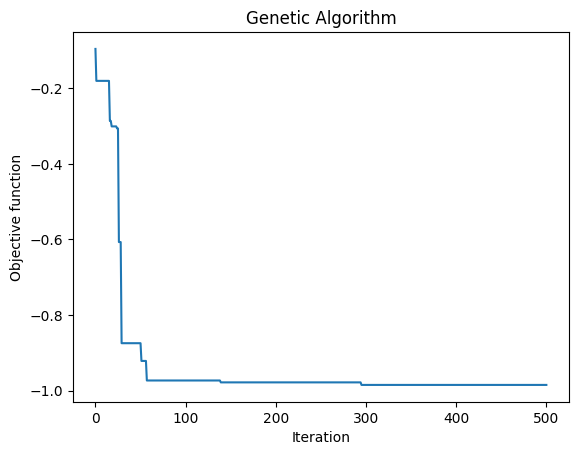

 The best solution found:                                                                           
 [ 7.  2.  7.  2. 17.  2.  0.  2.]

 Objective function:
 -0.9928647058480898


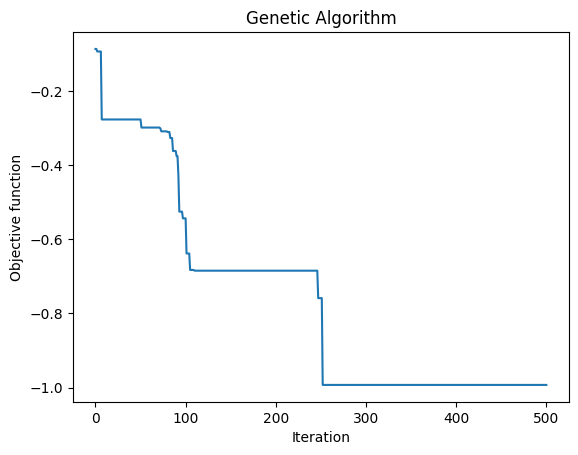

 The best solution found:                                                                           
 [ 6.  2.  5.  2. 14.  2.  0.  2.]

 Objective function:
 -0.9691667366189268


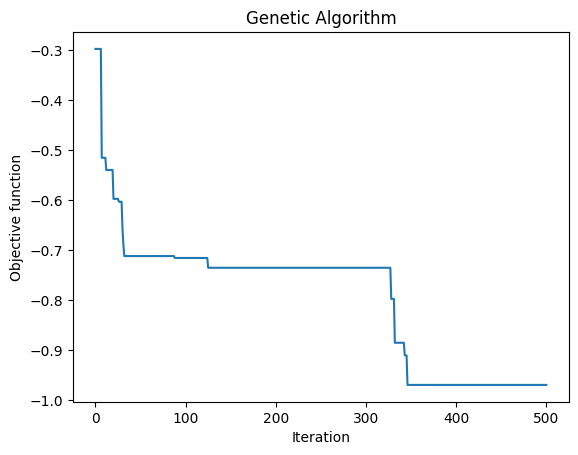

 The best solution found:                                                                           
 [12.  2.  1.  2. 10.  2.  6.  2.]

 Objective function:
 -0.9781414835535206


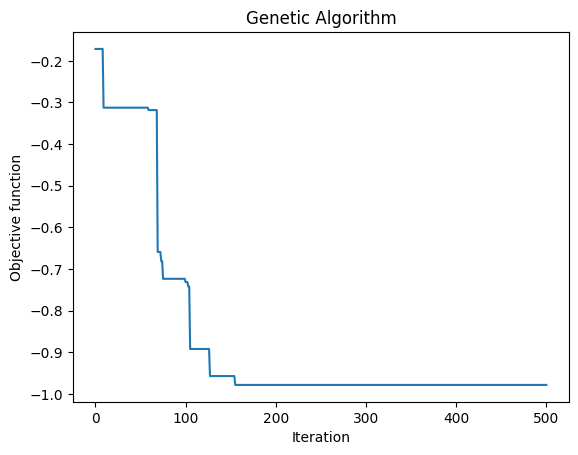

 The best solution found:                                                                           
 [10.  2.  4.  2. 14.  2.  3.  2.]

 Objective function:
 -0.9855982245972826


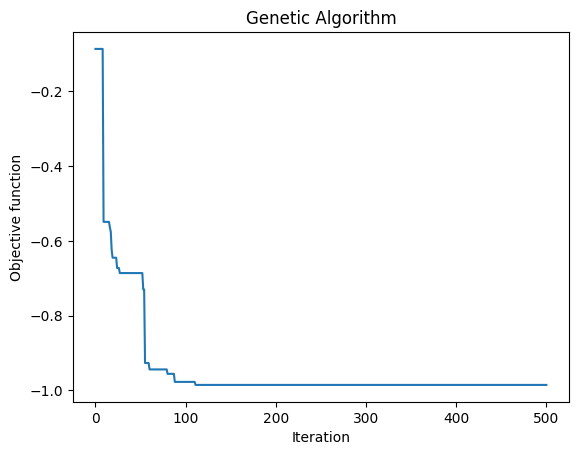

 The best solution found:                                                                           
 [11.  2.  1.  2. 10.  2.  5.  2.]

 Objective function:
 -0.9778271926455301


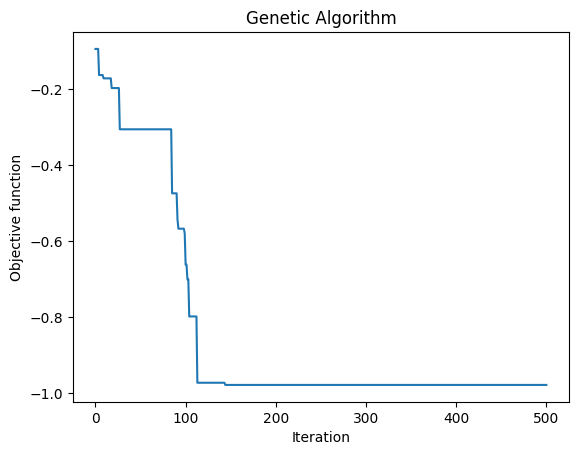

 The best solution found:                                                                           
 [ 8.  2.  7.  2. 17.  2.  1.  2.]

 Objective function:
 -0.9791570765693021


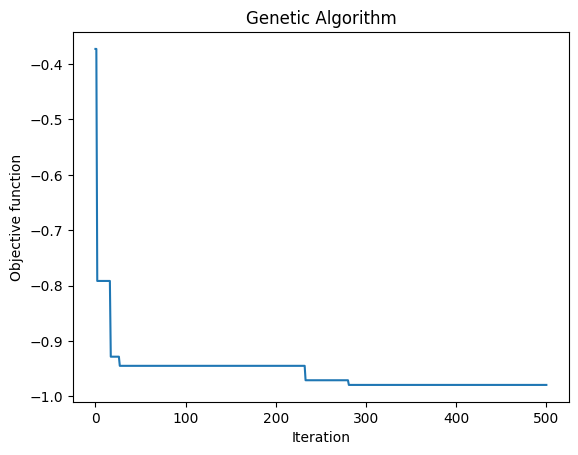

 The best solution found:                                                                           
 [12.  2.  2.  2. 11.  2.  6.  2.]

 Objective function:
 -0.98904878083362


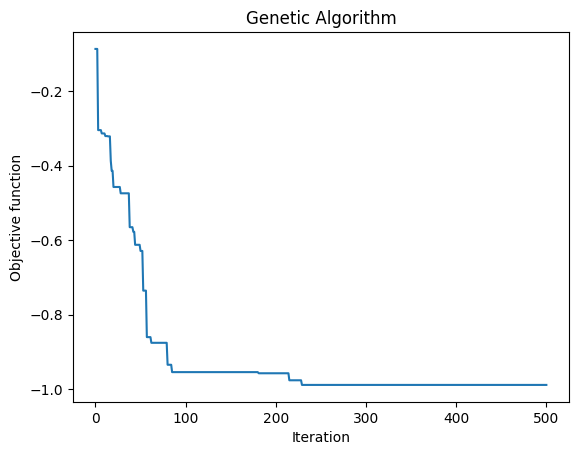

 The best solution found:                                                                           
 [12.  2.  2.  2. 11.  2.  6.  2.]

 Objective function:
 -0.98904878083362


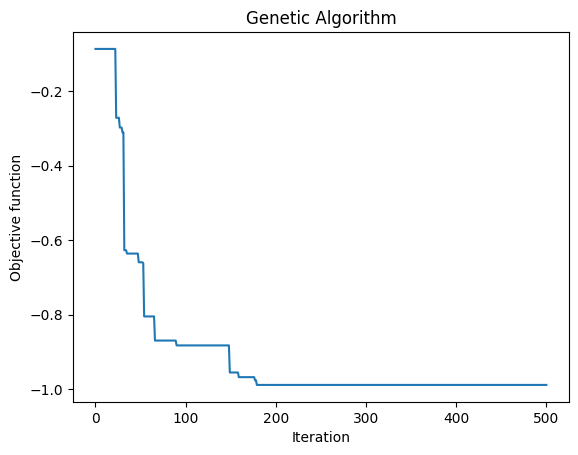

 The best solution found:                                                                           
 [13.  2.  3.  2. 12.  2.  6.  2.]

 Objective function:
 -0.9930817618496557


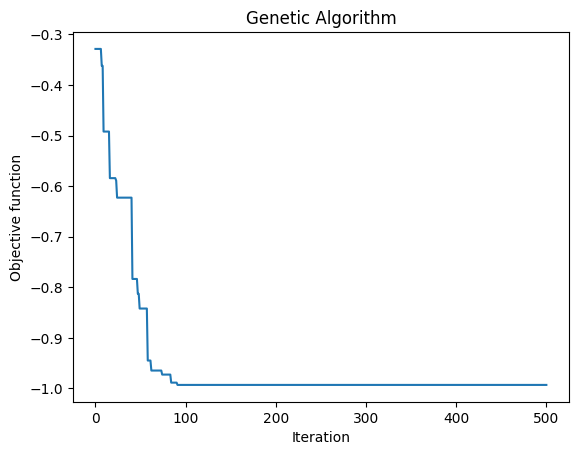

 The best solution found:                                                                           
 [11.  2. 14.  2.  0.  3.  4.  2.]

 Objective function:
 -0.7666492114882563


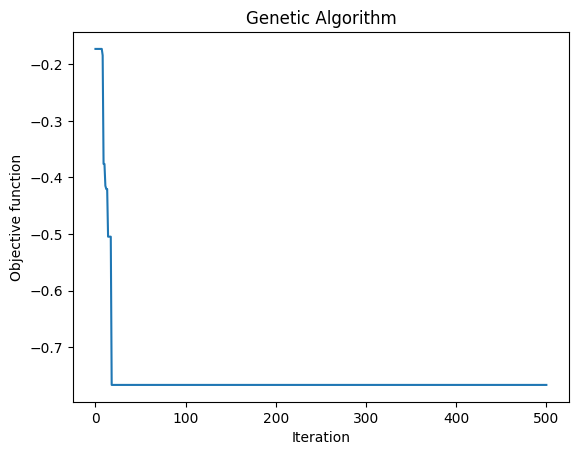

 The best solution found:                                                                           
 [ 9.  2.  6.  2. 16.  2.  2.  2.]

 Objective function:
 -1.004285811025872


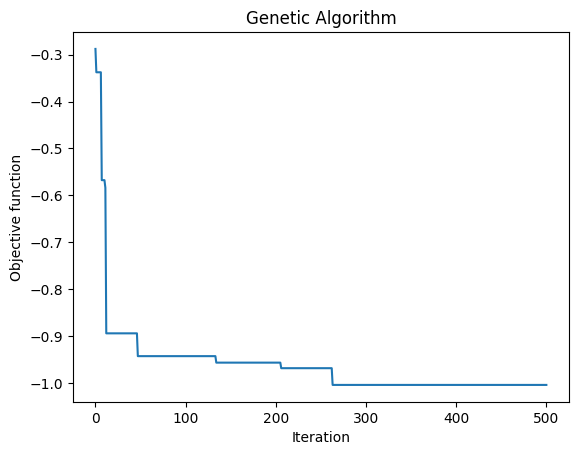

 The best solution found:                                                                           
 [14.  2.  4.  2. 14.  2.  7.  2.]

 Objective function:
 -0.9680455152113265


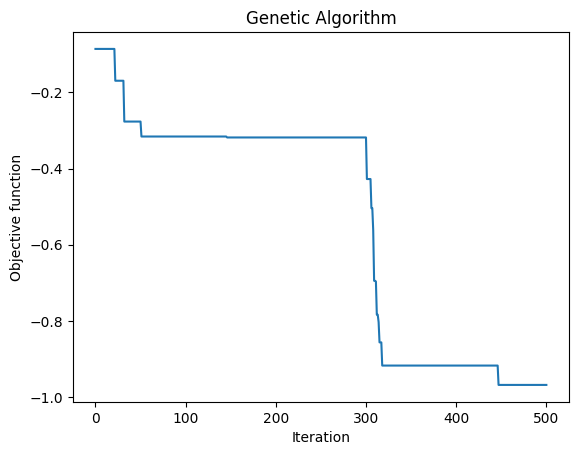

 The best solution found:                                                                           
 [11.  2.  1.  2. 10.  2.  5.  2.]

 Objective function:
 -0.9778271926455301


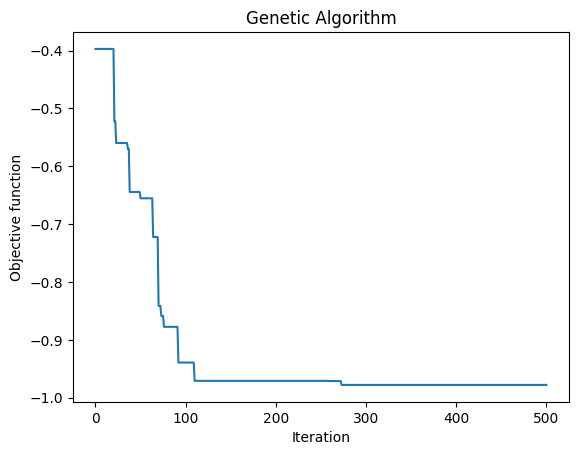

 The best solution found:                                                                           
 [ 9.  2.  5.  2. 15.  2.  2.  2.]

 Objective function:
 -0.9838535895262028


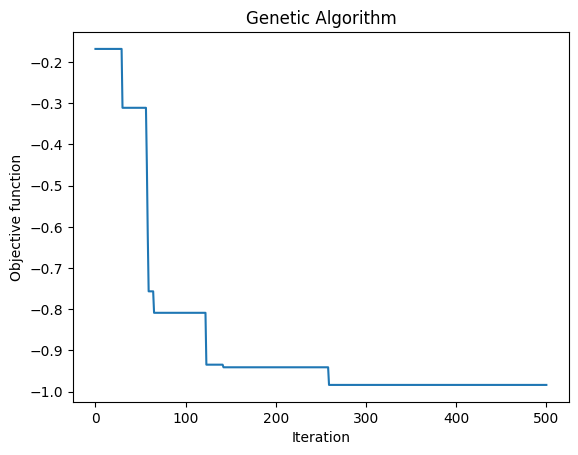

 The best solution found:                                                                           
 [21.  5. 19.  5. 16.  5. 16.  5.]

 Objective function:
 -0.31660770205861805


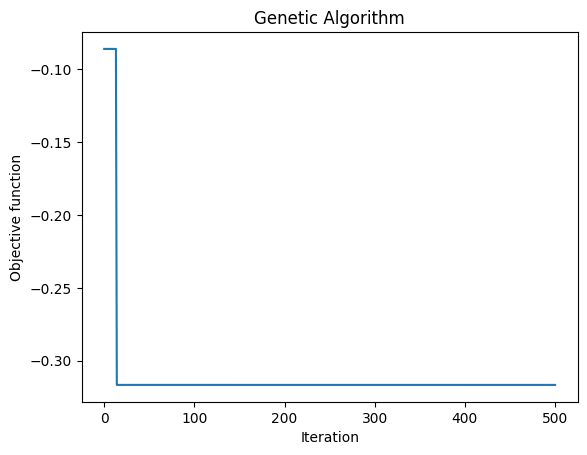

In [286]:
import numpy as np
from geneticalgorithm import geneticalgorithm as ga

varbound=np.array([[0,23], [2,5]]*4)

algorithm_param = {'max_num_iteration': 500,\
                   'population_size':20,\
                   'mutation_probability':0.15,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

history_z = None 

for i in range(20):
    z_model=ga(function=z_FP,\
                dimension=8,\
                variable_type='int',\
                variable_boundaries=varbound,\
                algorithm_parameters=algorithm_param)

    z_model.run()

    if history_z is None:
        history_z = np.array(z_model.report) 
    else:
        history_z = np.vstack((history_z,np.array(z_model.report)))

|||||||___________________________________________ 14.6% GA is running...

C:\Users\tmedeiros\AppData\Local\Temp\ipykernel_19896\2942314074.py:25: RuntimeWarning: overflow encountered in long_scalars
  Vout = -R[0]/R[3]*Vin + 3*(R[0]+R[3])*R[2]/(R[3]*(R[1]+R[2]))


 The best solution found:                                                                           
 [ 8.  2.  0.  2. 10.  2.  1.  2.]

 Objective function:
 -0.8937199189250664


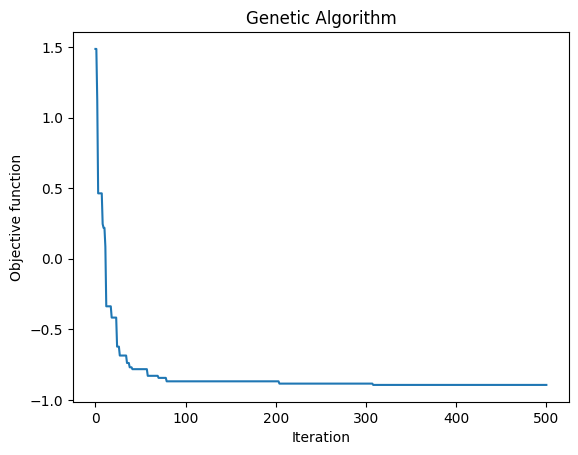

 The best solution found:                                                                           
 [6. 2. 0. 2. 9. 2. 0. 2.]

 Objective function:
 -0.8945975090972382


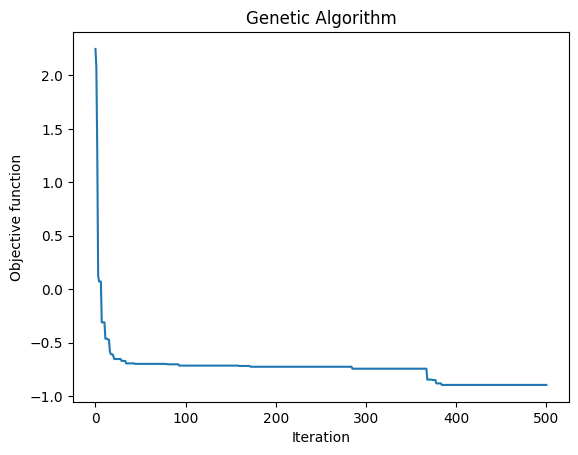

 The best solution found:                                                                           
 [ 7.  2.  3.  2. 12.  2.  0.  2.]

 Objective function:
 -0.8918750165050784


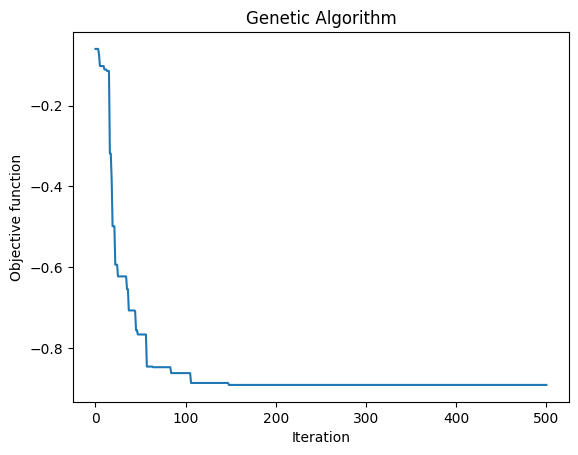

 The best solution found:                                                                           
 [ 7.  2. 15.  2.  1.  3.  0.  2.]

 Objective function:
 -0.7610563071428075


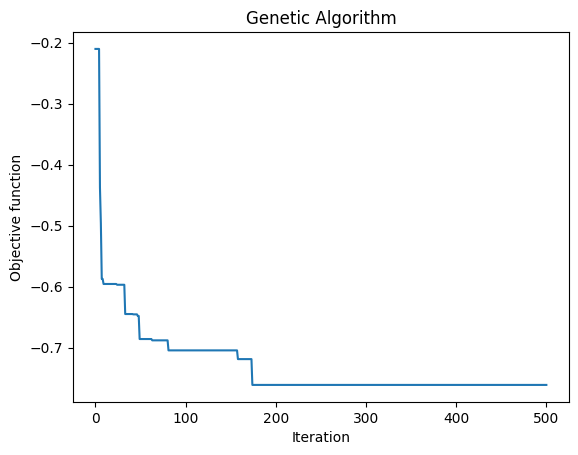

 The best solution found:                                                                           
 [11.  2.  3.  2. 12.  2.  5.  2.]

 Objective function:
 -0.8766607853690778


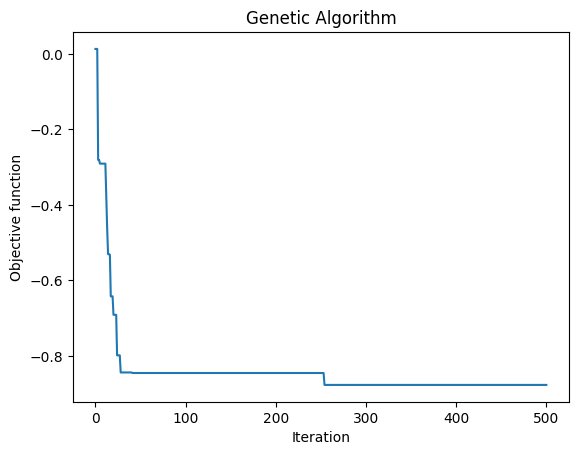

 The best solution found:                                                                           
 [ 6.  2.  2.  2. 11.  2.  0.  2.]

 Objective function:
 -0.8934389379864632


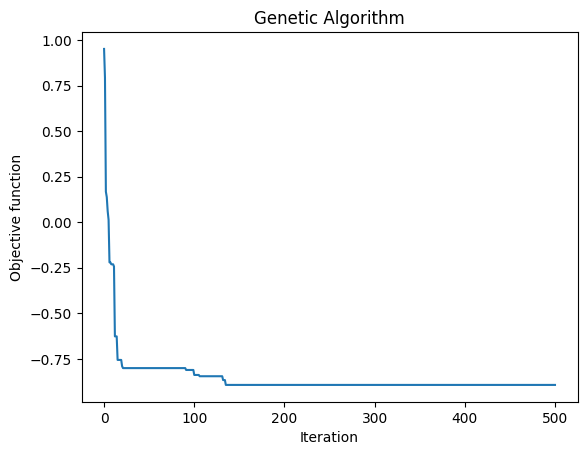

 The best solution found:                                                                           
 [ 9.  2.  2.  2. 11.  2.  3.  2.]

 Objective function:
 -0.8879095122292372


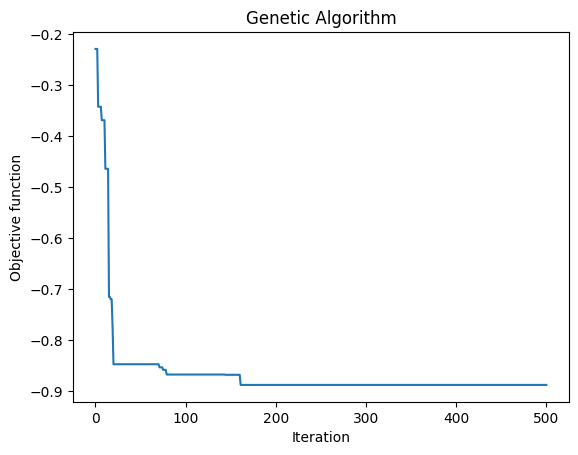

 The best solution found:                                                                           
 [ 7.  2.  2.  2. 11.  2.  1.  2.]

 Objective function:
 -0.8921817916830619


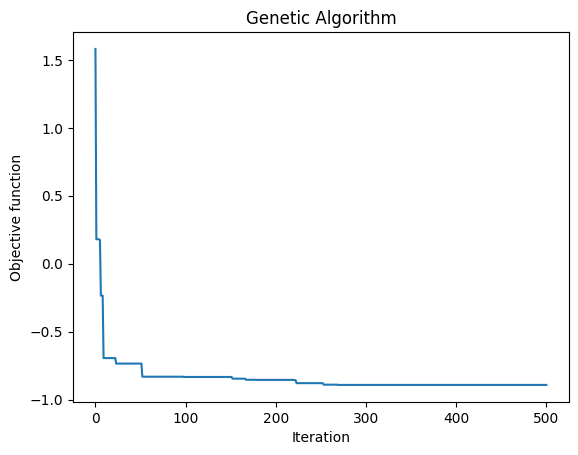

 The best solution found:                                                                           
 [ 9.  2.  0.  2. 10.  2.  2.  2.]

 Objective function:
 -0.8899699189250665


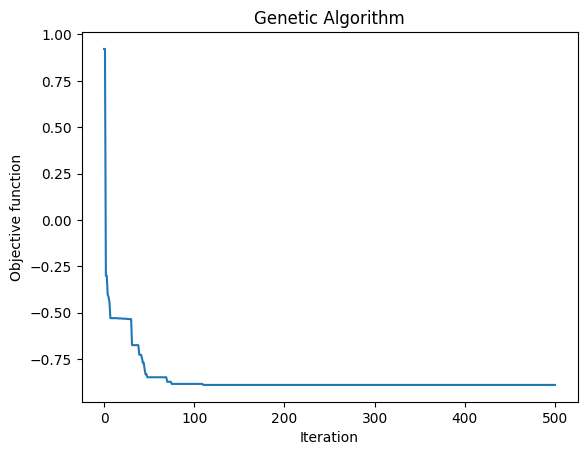

 The best solution found:                                                                           
 [ 7.  2.  0.  2. 10.  2.  0.  2.]

 Objective function:
 -0.8974699189250664


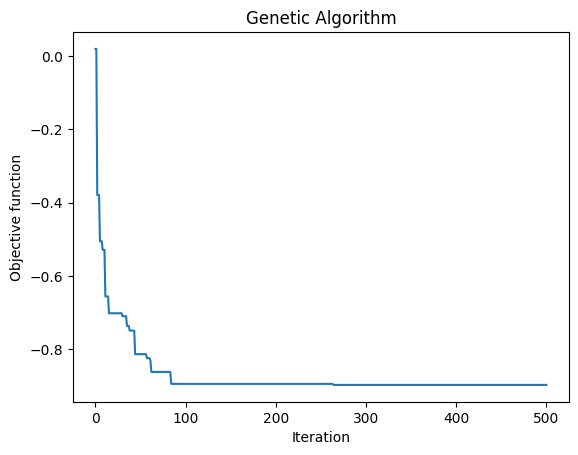

 The best solution found:                                                                           
 [ 8.  2.  3.  2. 12.  2.  1.  2.]

 Objective function:
 -0.8881250165050784


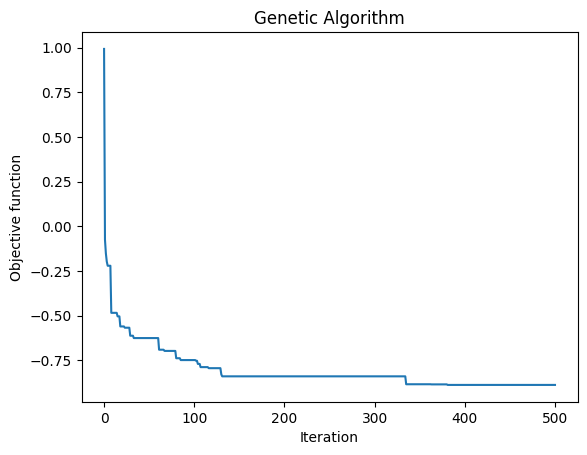

 The best solution found:                                                                           
 [ 8.  2.  3.  2. 12.  2.  1.  2.]

 Objective function:
 -0.8881250165050784


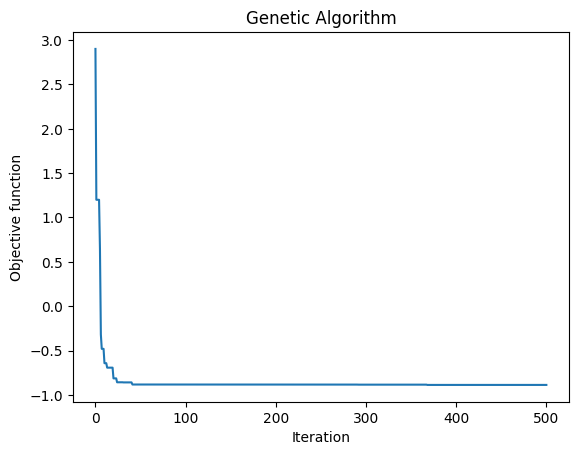

 The best solution found:                                                                           
 [ 7.  2. 14.  2.  0.  3.  0.  2.]

 Objective function:
 -0.7793420464079056


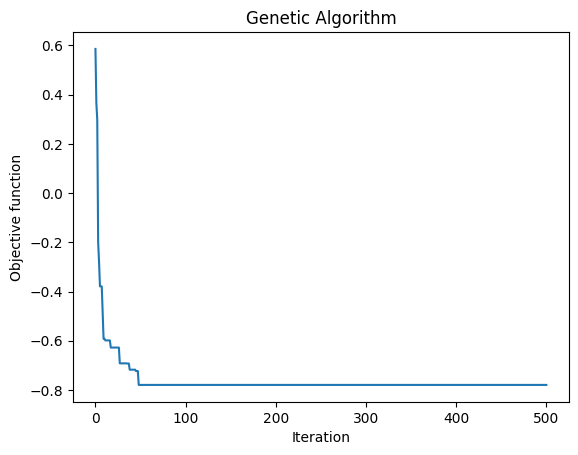

 The best solution found:                                                                           
 [ 7.  2.  2.  2. 11.  2.  1.  2.]

 Objective function:
 -0.8921817916830619


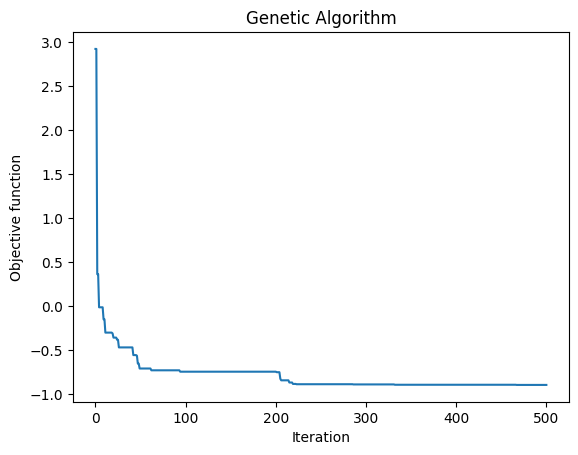

 The best solution found:                                                                           
 [ 7.  2.  0.  2. 10.  2.  0.  2.]

 Objective function:
 -0.8974699189250664


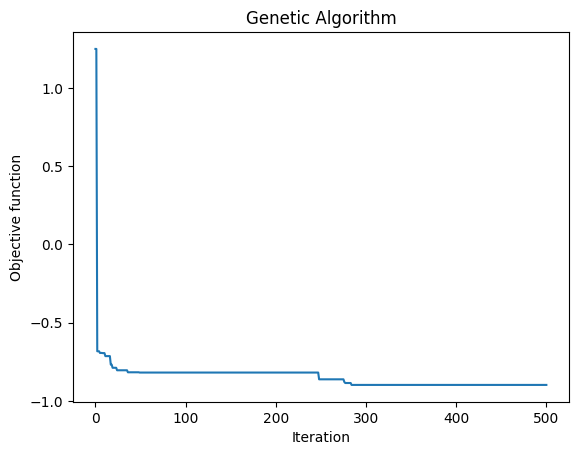

 The best solution found:                                                                           
 [ 7.  2.  4.  2. 14.  2.  0.  2.]

 Objective function:
 -0.8881999082952877


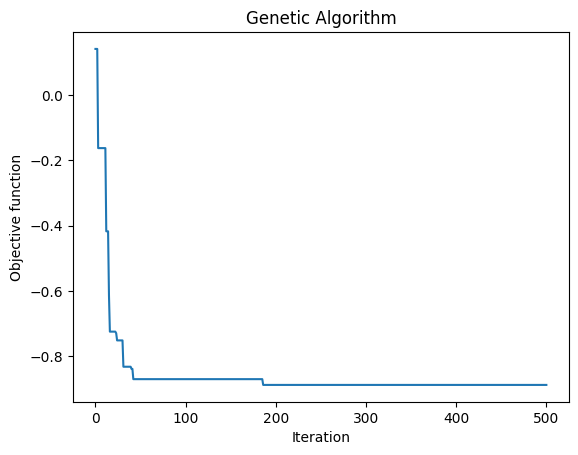

 The best solution found:                                                                           
 [ 8.  2.  4.  2. 14.  2.  1.  2.]

 Objective function:
 -0.8844499082952877


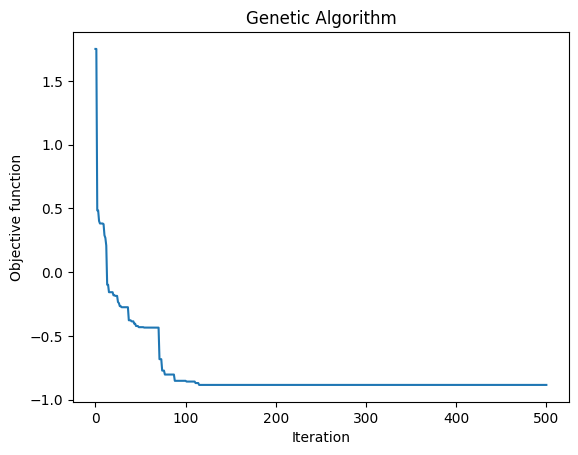

 The best solution found:                                                                           
 [ 8.  2.  3.  2. 12.  2.  1.  2.]

 Objective function:
 -0.8881250165050784


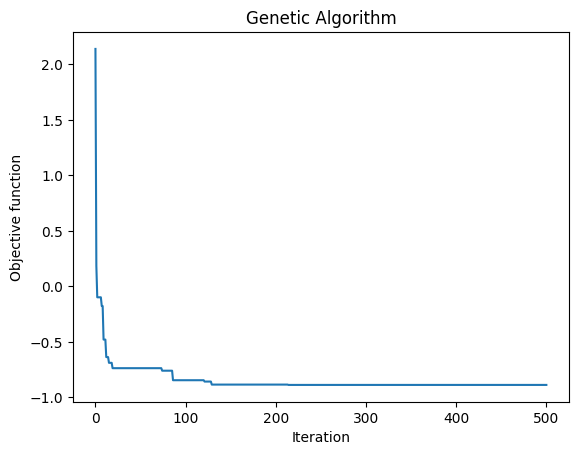

 The best solution found:                                                                           
 [11.  2.  2.  2. 11.  2.  5.  2.]

 Objective function:
 -0.8786275753914604


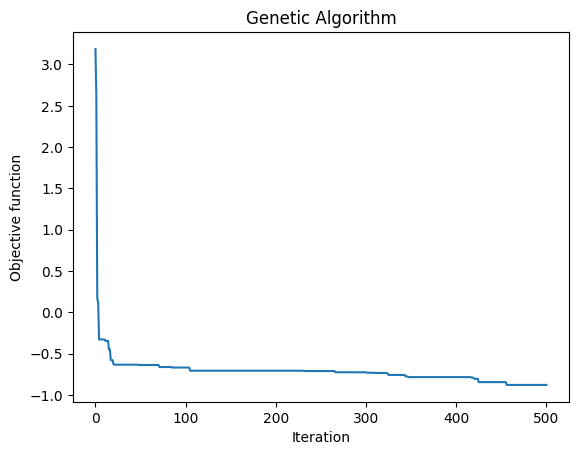

 The best solution found:                                                                           
 [7. 2. 0. 2. 9. 2. 1. 2.]

 Objective function:
 -0.8909645588459111


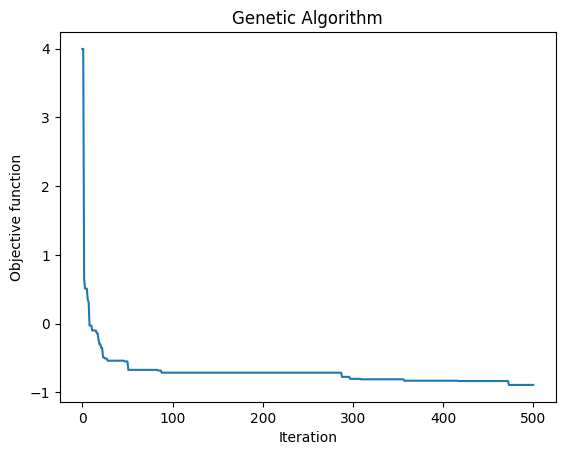

In [287]:
import numpy as np
from geneticalgorithm import geneticalgorithm as ga

varbound=np.array([[0,23], [2,5]]*4)

algorithm_param = {'max_num_iteration': 500,\
                   'population_size':20,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

history_z_mo = None
for i in range(20):
    z_model_mo=ga(function=z_FP_MO,\
                dimension=8,\
                variable_type='int',\
                variable_boundaries=varbound,\
                algorithm_parameters=algorithm_param)

    z_model_mo.run();

    if history_z_mo is None:
        history_z_mo = np.array(z_model_mo.report) 

    else:
        history_z_mo = np.vstack((history_z_mo,np.array(z_model_mo.report)))

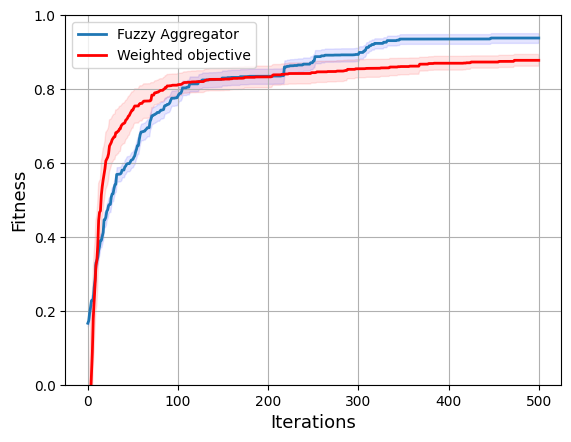

In [297]:

x_ = np.mean(-history_z,axis=0)
ci = 1.96 * np.std(-history_z,axis=0)/np.sqrt(history_z.shape[1])

plt.plot(x_, linewidth=2,label='Fuzzy Aggregator')
plt.fill_between(np.arange(len(x_)),(x_-ci), (x_+ci), color='b', alpha=.1)

x_ = np.mean(-history_z_mo,axis=0)
ci = 1.96 * np.std(-history_z_mo,axis=0)/np.sqrt(history_z_mo.shape[0])

plt.plot(x_, color='r', linewidth=2, label='Weighted objective')
plt.fill_between(np.arange(len(x_)),(x_-ci), (x_+ci), color='r', alpha=.1)

plt.ylim([0,1])

plt.xlabel('Iterations',fontsize=13)
plt.ylabel('Fitness',fontsize=13)
plt.legend()
plt.grid()

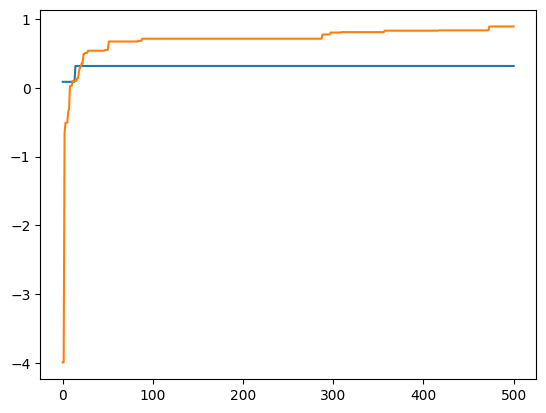

In [289]:
plt.plot(-np.array(z_model.report))
plt.plot(-np.array(z_model_mo.report))

C:\Users\tmedeiros\AppData\Local\Temp\ipykernel_19896\2288529405.py:6: RuntimeWarning: overflow encountered in long_scalars
  Vout = -R[0]/R[3]*Vin + 3*(R[0]+R[3])*R[2]/(R[3]*(R[1]+R[2]))


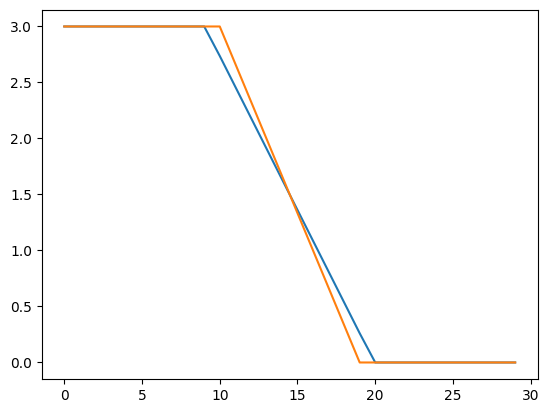

In [298]:
X = z_model.output_dict['variable']

X = X.astype('int')
R = [R_VALUES[X[i]]*10**(X[i+1]) for i in range(0, X.shape[0], 2)]

Vout = -R[0]/R[3]*Vin + 3*(R[0]+R[3])*R[2]/(R[3]*(R[1]+R[2]))
Vout[Vout>3] = 3
Vout[Vout<0] = 0

plt.plot(Vout)
plt.plot(Vref_z)

 The best solution found:                                                                           
 [10.  2.  0.  2. 14.  2.]

 Objective function:
 -0.7377599029534798


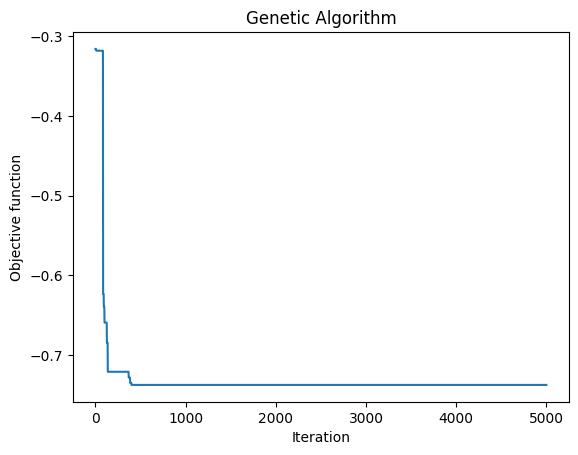

In [194]:
import numpy as np
from geneticalgorithm import geneticalgorithm as ga

varbound=np.array([[0,23], [2,5]]*3)

algorithm_param = {'max_num_iteration': 5000,\
                   'population_size':30,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

model=ga(function=s_FP,\
            dimension=6,\
            variable_type='int',\
            variable_boundaries=varbound,\
            algorithm_parameters=algorithm_param)

model.run()

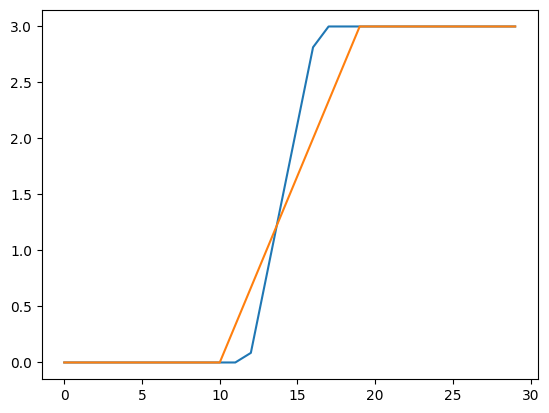

In [195]:
X = model.output_dict['variable']
X = X.astype('int')
R = [R_VALUES[X[i]]*10**(X[i+1]) for i in range(0, X.shape[0], 2)]

Vout = (1 + R[0]/R[1] + R[1]/R[2])*Vin - 3*R[0]/R[1]
Vout[Vout>3] = 3
Vout[Vout<0] = 0

plt.plot(Vout)
plt.plot(Vref_s)

In [307]:
#R = [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]


def tri_FP(X):
    X = X.astype('int')
    R = [R_VALUES[X[i]]*10**(X[i+1]) for i in range(0, X.shape[0], 2)]
    Vin0 = (1 + R[0]/R[1] + R[1]/R[2])*Vin - 3*R[0]/R[1]

    Vin1 = -R[4]/R[3]*Vin + 3*R[6]/R[3]*(R[4]+R[3])/(R[5]+R[6])

    Vin0[Vin0 > 3] = 3 
    Vin0[Vin0 < 0] = 0

    Vin1[Vin1 > 3] = 3 
    Vin1[Vin1 < 0] = 0

    # Vinf = Vin0*R[7]/(R[7]+R[8]) + Vin1*R[8]/(R[7]+R[8])

    # Vout = Vinf*(1 + R[9]/R[10])

    # Vout[Vout > 3] = 3 
    # Vout[Vout < 0] = 0

    Vout = np.minimum(Vin0,Vin1)

    rmse_val = np.sqrt(((Vout - Vref_tri) ** 2).mean())
    sum_r_val = np.sum(R)/100000

    evaluator.input['rmse'] = rmse_val
    evaluator.input['sum_r'] = sum_r_val

    # Crunch the numbers
    evaluator.compute()
    
    return -evaluator.output['evaluation']

#R = [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]


def tri_FP_MO(X):
    X = X.astype('int')
    R = [R_VALUES[X[i]]*10**(X[i+1]) for i in range(0, X.shape[0], 2)]
    Vin0 = (1 + R[0]/R[1] + R[1]/R[2])*Vin - 3*R[0]/R[1]

    Vin1 = -R[4]/R[3]*Vin + 3*R[6]/R[3]*(R[4]+R[3])/(R[5]+R[6])

    Vin0[Vin0 > 3] = 3 
    Vin0[Vin0 < 0] = 0

    Vin1[Vin1 > 3] = 3 
    Vin1[Vin1 < 0] = 0

    # Vinf = Vin0*R[7]/(R[7]+R[8]) + Vin1*R[8]/(R[7]+R[8])

    # Vout = Vinf*(1 + R[9]/R[10])

    # Vout[Vout > 3] = 3 
    # Vout[Vout < 0] = 0

    Vout = np.minimum(Vin0,Vin1)

    rmse_val = np.sqrt(((Vout - Vref_tri) ** 2).mean())
    sum_r_val = np.sum(R)/100000

    res = 1 - (0.5*rmse_val + 0.5*sum_r_val)

    return -res

In [309]:
#R = [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]

def trap_FP(X):
    X = X.astype('int')
    R = [R_VALUES[X[i]]*10**(X[i+1]) for i in range(0, X.shape[0], 2)]
    Vin0 = (1 + R[0]/R[1] + R[1]/R[2])*Vin - 3*R[0]/R[1]

    Vin1 = -R[4]/R[3]*Vin + 3*R[6]/R[3]*(R[4]+R[3])/(R[5]+R[6])

    Vin0[Vin0 > 3] = 3 
    Vin0[Vin0 < 0] = 0

    Vin1[Vin1 > 3] = 3 
    Vin1[Vin1 < 0] = 0

    # Vinf = Vin0*R[7]/(R[7]+R[8]) + Vin1*R[8]/(R[7]+R[8])

    # Vout = Vinf*(1 + R[9]/R[10])

    # Vout[Vout > 3] = 3 
    # Vout[Vout < 0] = 0

    Vout = np.minimum(Vin0,Vin1)

    rmse_val = np.sqrt(((Vout - Vref_trap) ** 2).mean())
    sum_r_val = np.sum(R)/100000

    evaluator.input['rmse'] = rmse_val
    evaluator.input['sum_r'] = sum_r_val

    # Crunch the numbers
    evaluator.compute()
    
    return -evaluator.output['evaluation']

#R = [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]

def trap_FP_MO(X):
    X = X.astype('int')
    R = [R_VALUES[X[i]]*10**(X[i+1]) for i in range(0, X.shape[0], 2)]
    Vin0 = (1 + R[0]/R[1] + R[1]/R[2])*Vin - 3*R[0]/R[1]

    Vin1 = -R[4]/R[3]*Vin + 3*R[6]/R[3]*(R[4]+R[3])/(R[5]+R[6])

    Vin0[Vin0 > 3] = 3 
    Vin0[Vin0 < 0] = 0

    Vin1[Vin1 > 3] = 3 
    Vin1[Vin1 < 0] = 0

    # Vinf = Vin0*R[7]/(R[7]+R[8]) + Vin1*R[8]/(R[7]+R[8])

    # Vout = Vinf*(1 + R[9]/R[10])

    # Vout[Vout > 3] = 3 
    # Vout[Vout < 0] = 0

    Vout = np.minimum(Vin0,Vin1)

    rmse_val = np.sqrt(((Vout - Vref_trap) ** 2).mean())
    sum_r_val = np.sum(R)/100000

    res = 1 - (0.5*rmse_val + 0.5*sum_r_val)


    return -res



In [299]:
Vref_tri = np.concatenate((np.zeros(10), np.linspace(0,3,5), np.linspace(2.5,0,5), np.zeros(10)))
Vref_trap = np.concatenate((np.zeros(8), np.linspace(0,3,5), np.ones(4)*3, np.linspace(3,0,5), np.zeros(8)))

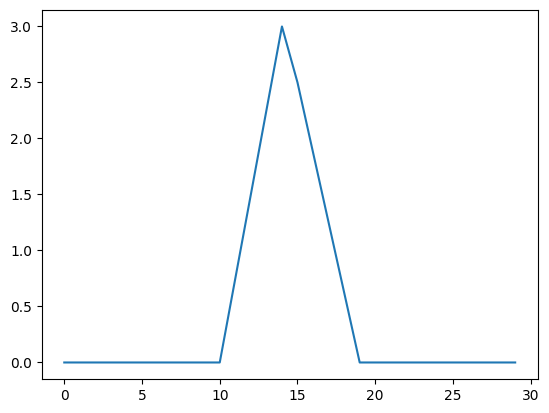

In [300]:
plt.plot(Vref_tri)

 The best solution found:                                                                           
 [17.  2.  6.  2.  6.  2.  0.  2. 12.  2.  6.  2.  0.  3.]

 Objective function:
 -0.9765214560463183


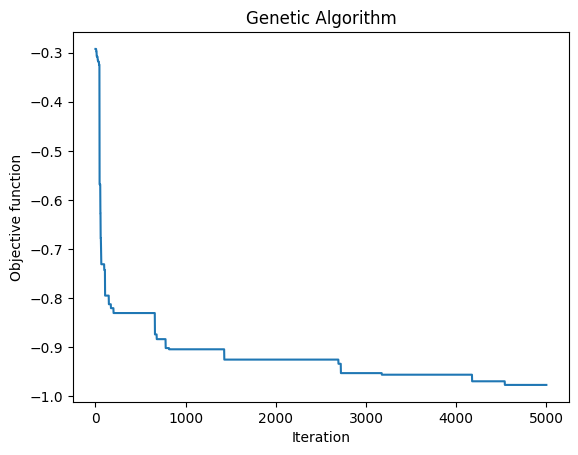

 The best solution found:                                                                           
 [ 0.  3. 13.  2. 13.  2.  0.  2. 12.  2.  0.  2. 18.  2.]

 Objective function:
 -0.9226029852270629


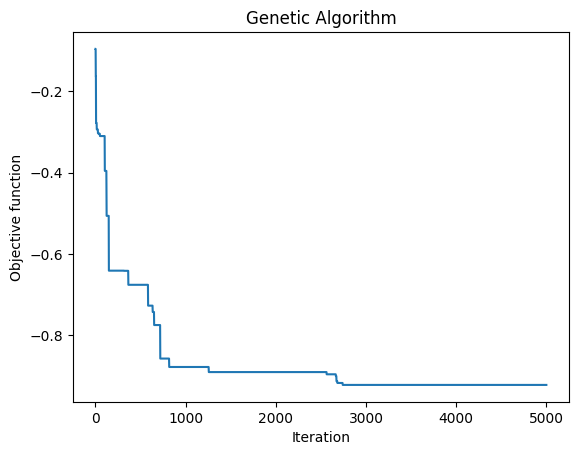

 The best solution found:                                                                           
 [14.  3.  5.  3.  7.  3. 18.  4. 11.  5. 19.  3. 16.  4.]

 Objective function:
 -0.3236711509485396


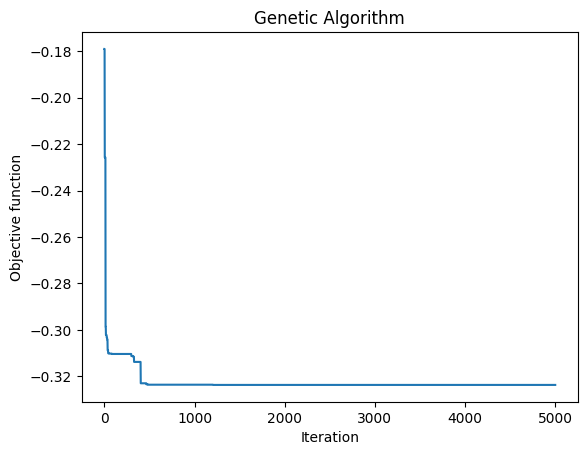

 The best solution found:                                                                           
 [12.  2.  2.  2.  2.  2.  6.  2. 20.  2.  5.  2.  0.  3.]

 Objective function:
 -0.9637495758585186


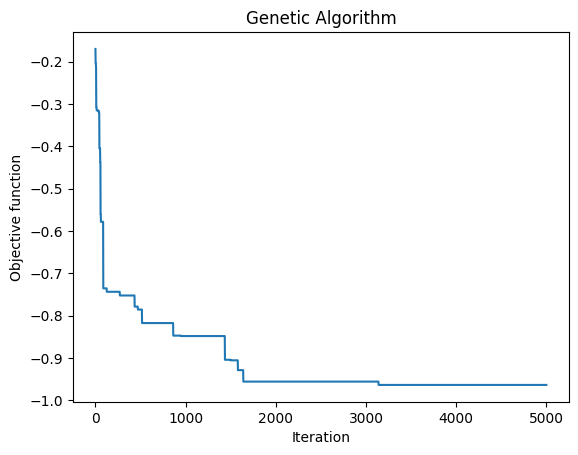

 The best solution found:                                                                           
 [19.  2.  9.  2. 10.  2.  1.  2. 14.  2.  3.  2. 21.  2.]

 Objective function:
 -1.0093161283237566


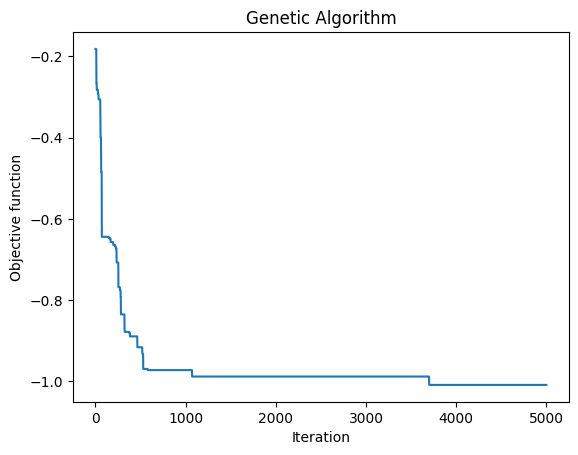

 The best solution found:                                                                           
 [10.  2.  1.  2.  3.  2.  3.  2. 16.  2.  4.  2. 23.  2.]

 Objective function:
 -0.9960214522687217


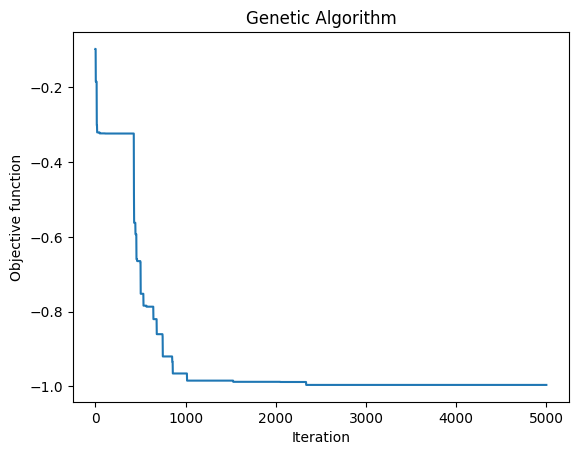

 The best solution found:                                                                           
 [ 2.  4. 13.  3. 12.  3.  0.  4. 11.  4.  9.  4.  3.  5.]

 Objective function:
 -0.32355849400847003


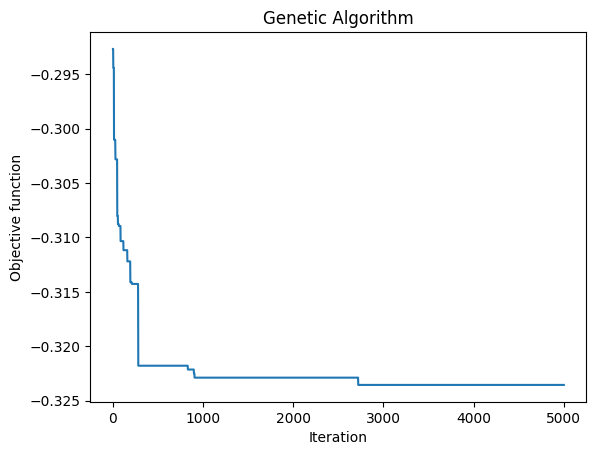

 The best solution found:                                                                           
 [19.  2.  9.  2. 10.  2.  4.  2. 18.  2.  0.  2. 19.  2.]

 Objective function:
 -0.9914545361917158


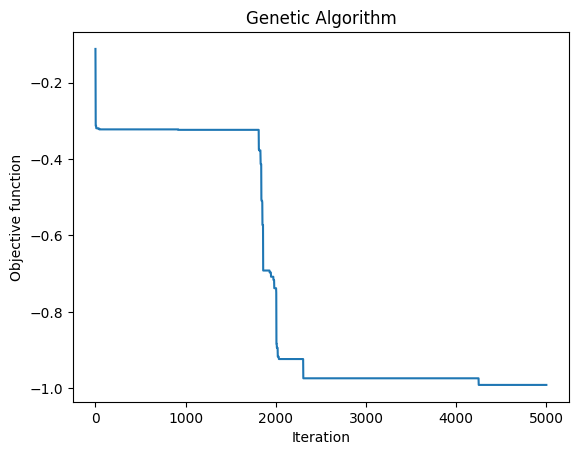

 The best solution found:                                                                           
 [16.  2.  6.  2.  7.  2.  6.  2. 20.  2.  1.  2. 20.  2.]

 Objective function:
 -1.0060181152597985


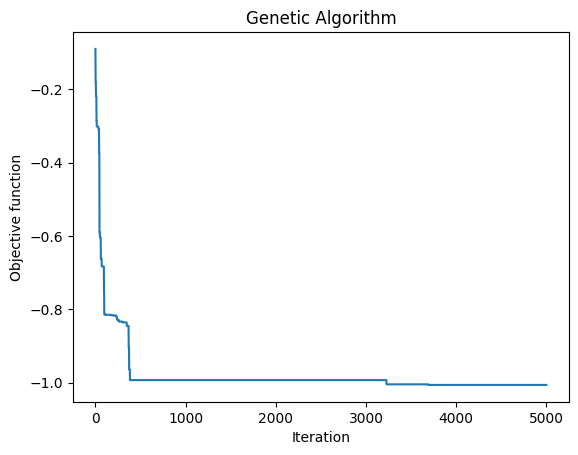

 The best solution found:                                                                           
 [10.  2.  1.  2.  3.  2.  1.  2. 14.  2. 10.  2.  5.  3.]

 Objective function:
 -0.9443285551938304


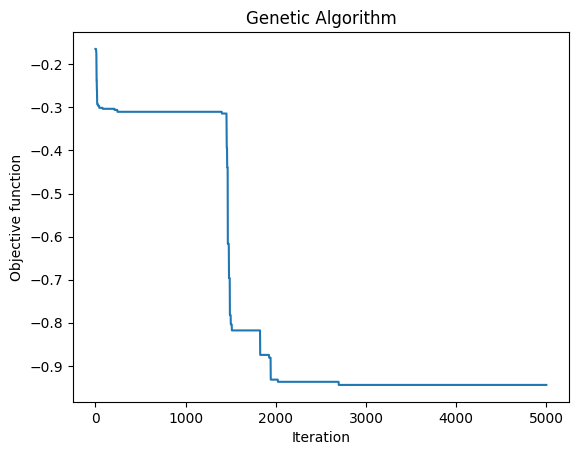

 The best solution found:                                                                           
 [19.  5.  9.  5.  9.  5.  8.  2. 21.  2.  9.  3.  2.  4.]

 Objective function:
 -0.32353111517276073


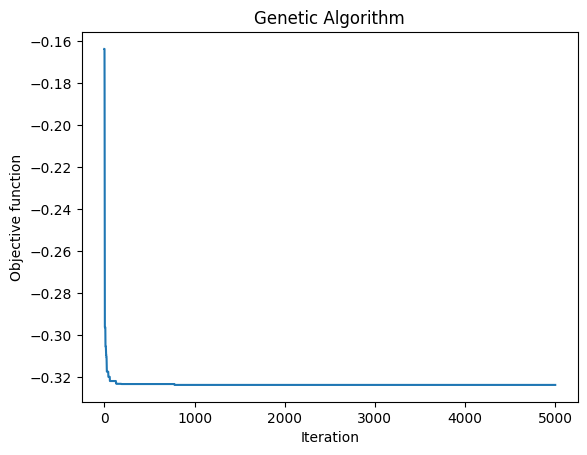

 The best solution found:                                                                           
 [20.  3.  9.  3.  8.  3.  5.  4. 21.  4.  1.  5. 20.  5.]

 Objective function:
 -0.3235718646863689


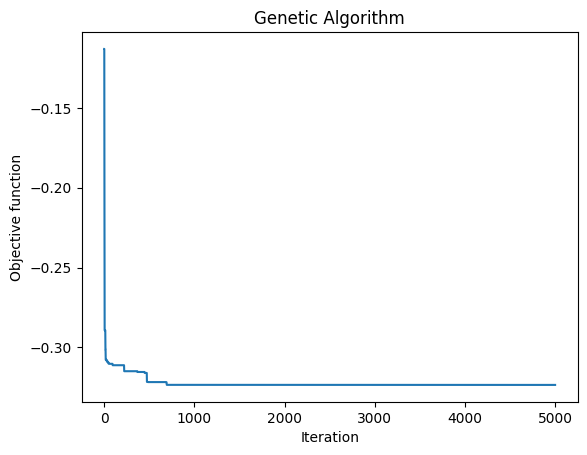

 The best solution found:                                                                           
 [10.  2.  1.  2.  3.  2.  3.  2. 16.  2.  6.  2.  1.  3.]

 Objective function:
 -0.9936465166751458


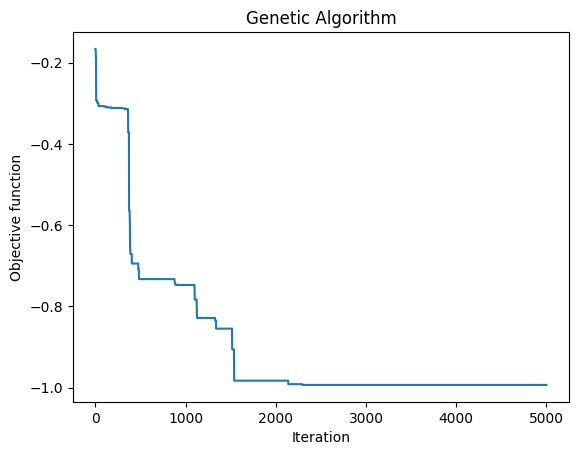

 The best solution found:                                                                           
 [10.  2.  0.  2.  1.  2. 10.  2.  0.  3.  0.  2. 19.  2.]

 Objective function:
 -0.9872765716310765


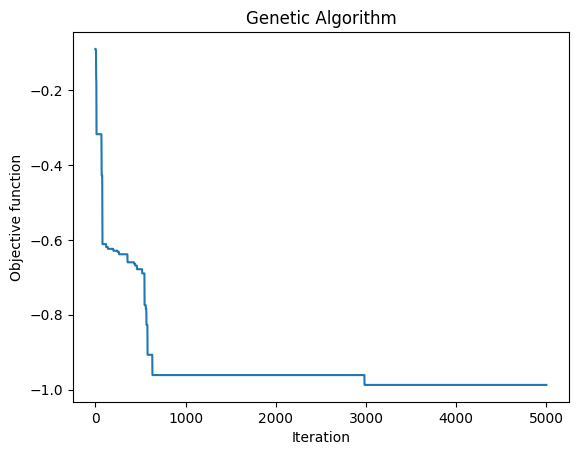

 The best solution found:                                                                           
 [12.  2.  2.  2.  2.  2.  3.  2. 16.  2.  7.  2.  2.  3.]

 Objective function:
 -0.9732630271835904


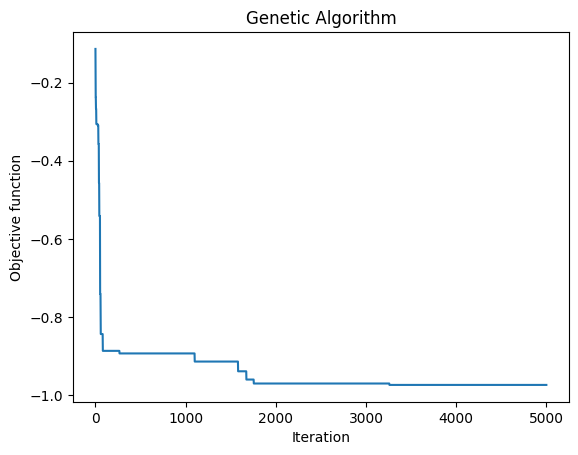

 The best solution found:                                                                           
 [12.  2.  2.  2.  2.  2.  2.  2. 15.  2.  7.  2.  2.  3.]

 Objective function:
 -0.9801929531012396


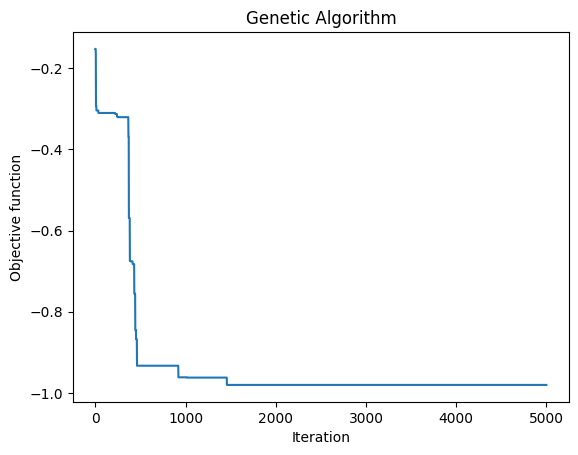

 The best solution found:                                                                           
 [17.  3.  9.  3. 15.  3. 21.  2. 10.  3. 20.  3. 14.  4.]

 Objective function:
 -0.32362055752866103


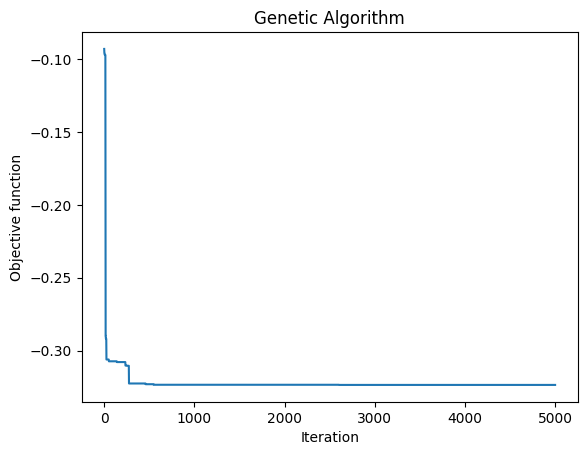

 The best solution found:                                                                           
 [10.  2.  1.  2.  3.  2.  3.  2. 15.  2.  8.  2.  2.  3.]

 Objective function:
 -0.9784735841125394


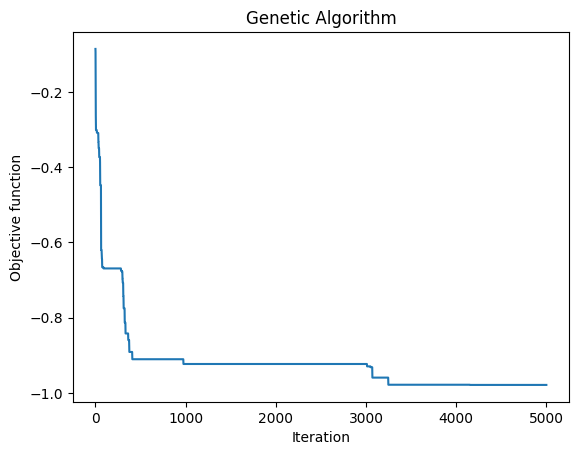

 The best solution found:                                                                           
 [16.  2.  7.  2. 10.  2.  2.  2. 16.  2.  1.  2. 20.  2.]

 Objective function:
 -0.9660137058291353


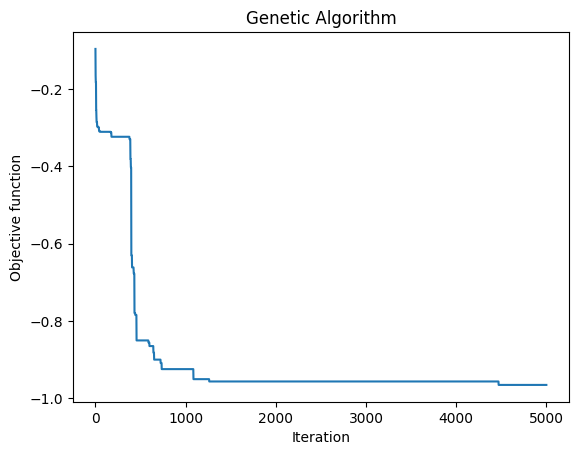

 The best solution found:                                                                           
 [ 5.  4. 22.  3.  5.  4. 10.  4.  1.  5.  4.  3. 23.  3.]

 Objective function:
 -0.3236307222738481


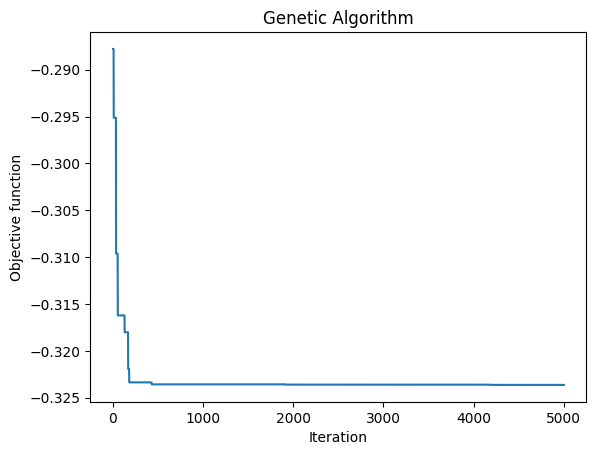

In [312]:
import numpy as np
from geneticalgorithm import geneticalgorithm as ga

varbound=np.array([[0,23], [2,5]]*7)


algorithm_param = {'max_num_iteration': 5000,\
                   'population_size':25,\
                   'mutation_probability':0.15,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

tri_history = None 

for i in range(20):
    tri_model=ga(function=tri_FP,\
                dimension=14,\
                variable_type='int',\
                variable_boundaries=varbound,\
                algorithm_parameters=algorithm_param)

    tri_model.run()

    if tri_history is None:
        tri_history = np.array(tri_model.report)

    else:
        tri_history = np.vstack((tri_history,np.array(tri_model.report)))

 The best solution found:                                                                           
 [10.  2.  0.  2.  1.  2.  0.  2. 14.  2.  0.  2. 19.  2.]

 Objective function:
 -0.9003606194023366


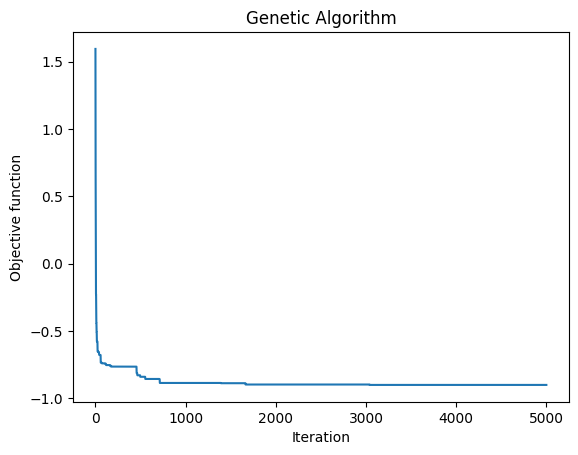

 The best solution found:                                                                           
 [11.  2.  1.  2.  2.  2.  2.  2. 15.  2.  0.  2. 18.  2.]

 Objective function:
 -0.8918003663670976


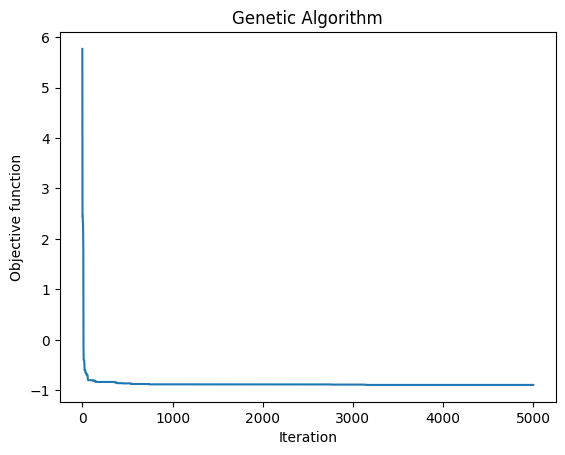

 The best solution found:                                                                           
 [ 9.  2.  0.  2.  2.  2.  1.  2. 14.  2.  0.  2. 18.  2.]

 Objective function:
 -0.8993248213506815


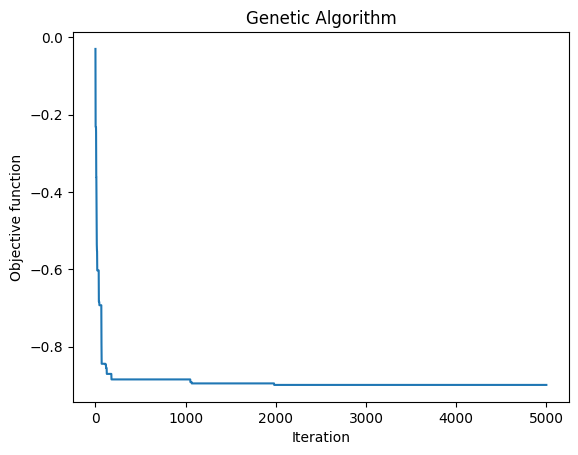

 The best solution found:                                                                           
 [ 9.  2.  0.  2.  2.  2.  0.  2. 12.  2.  0.  2. 18.  2.]

 Objective function:
 -0.9010241726185022


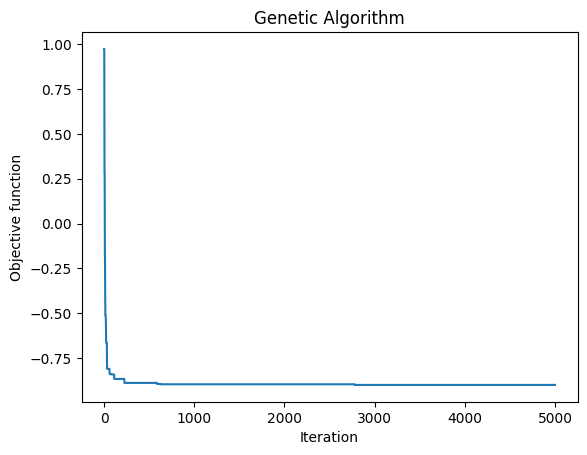

 The best solution found:                                                                           
 [12.  2.  3.  2.  4.  2.  0.  2. 14.  2.  0.  2. 19.  2.]

 Objective function:
 -0.8992402413250168


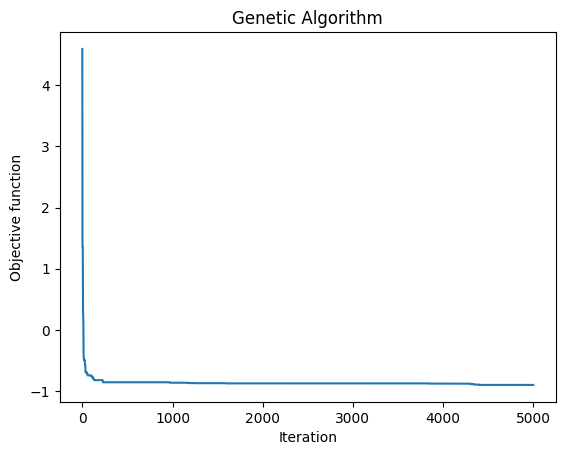

 The best solution found:                                                                           
 [10.  2.  1.  2.  3.  2.  0.  2. 12.  2.  0.  2. 18.  2.]

 Objective function:
 -0.901565338515588


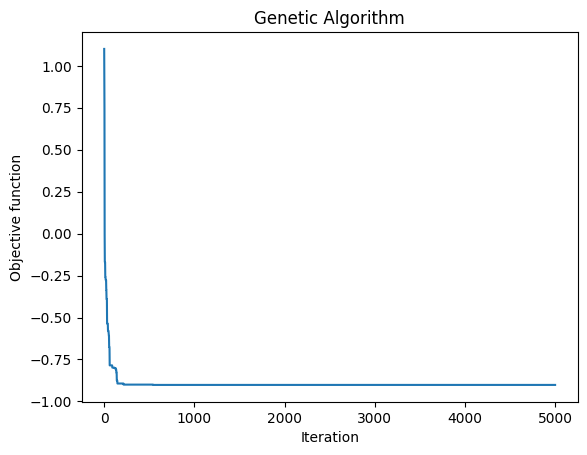

 The best solution found:                                                                           
 [14.  2.  5.  2.  7.  2.  0.  2. 12.  2.  0.  2. 18.  2.]

 Objective function:
 -0.8879968363058266


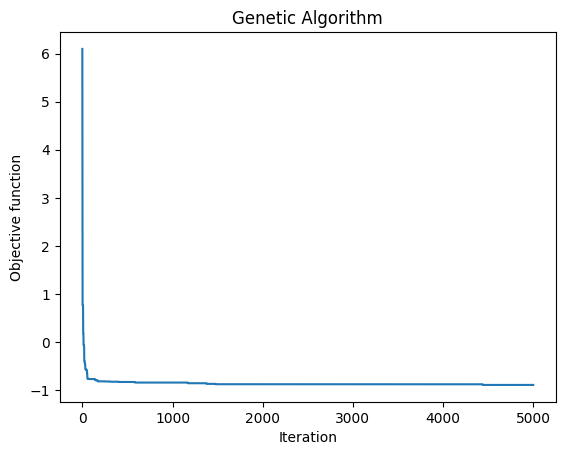

 The best solution found:                                                                           
 [12.  2.  3.  2.  4.  2.  1.  2. 15.  2.  0.  2. 19.  2.]

 Objective function:
 -0.8964214456392081


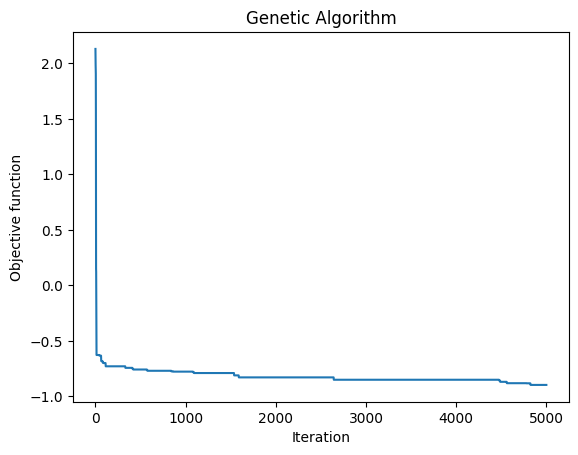

 The best solution found:                                                                           
 [10.  2.  1.  2.  3.  2.  0.  2. 12.  2.  0.  2. 18.  2.]

 Objective function:
 -0.901565338515588


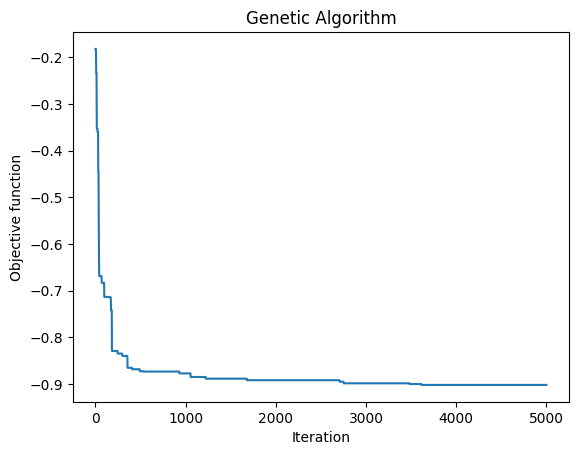

 The best solution found:                                                                           
 [12.  2.  3.  2.  4.  2.  2.  2. 16.  2.  5.  2.  0.  3.]

 Objective function:
 -0.8714744241731658


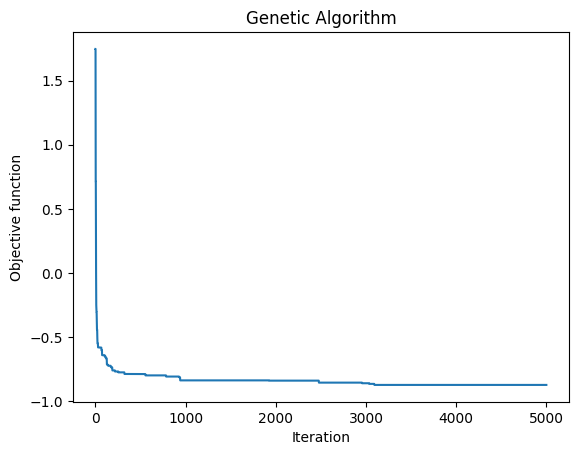

 The best solution found:                                                                           
 [ 9.  2.  0.  2.  2.  2.  0.  2. 12.  2.  6.  2.  0.  3.]

 Objective function:
 -0.8753108832928509


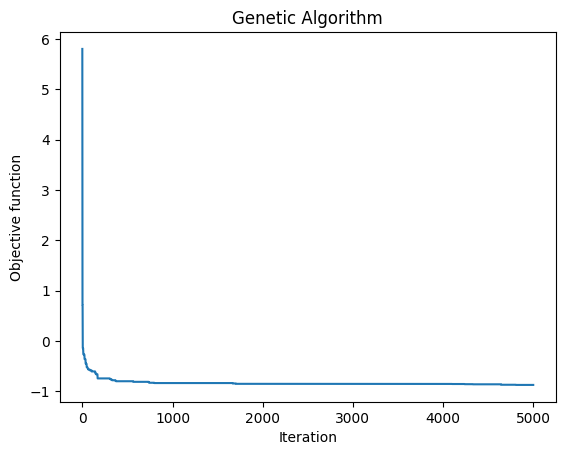

 The best solution found:                                                                           
 [12.  2.  3.  2.  4.  2.  0.  2. 14.  2.  1.  2. 20.  2.]

 Objective function:
 -0.8957124126789274


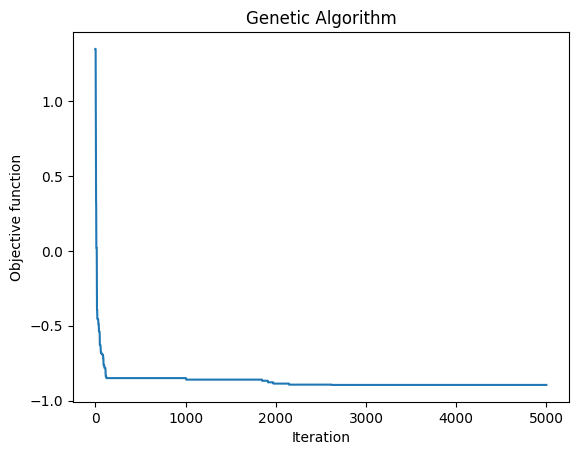

 The best solution found:                                                                           
 [10.  2.  1.  2.  3.  2.  0.  2. 13.  2.  1.  2. 19.  2.]

 Objective function:
 -0.8981194775408057


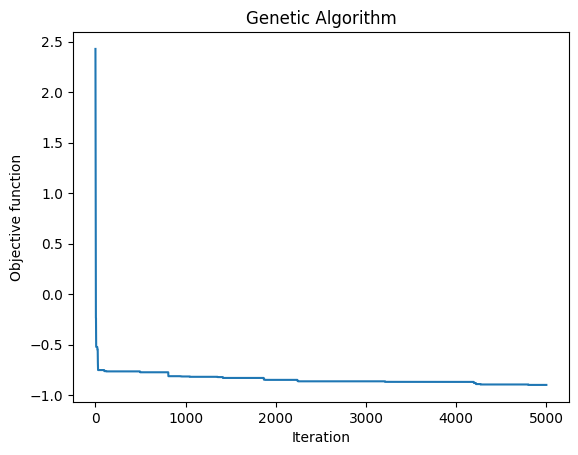

 The best solution found:                                                                           
 [ 0.  3. 13.  2. 13.  2.  0.  2. 14.  2.  5.  2.  0.  3.]

 Objective function:
 -0.8154126315981464


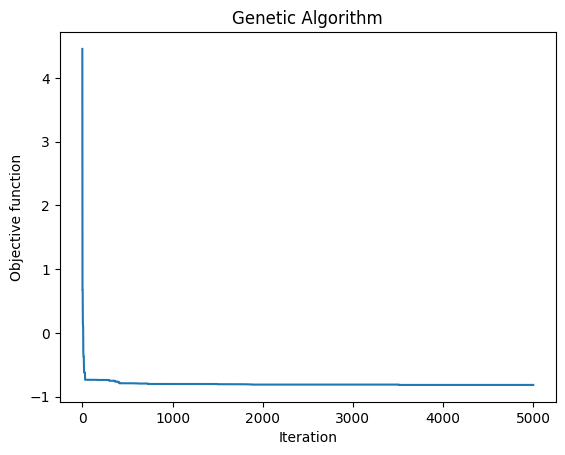

 The best solution found:                                                                           
 [15.  2.  6.  2.  8.  2.  0.  2. 12.  2.  0.  2. 18.  2.]

 Objective function:
 -0.884111238202282


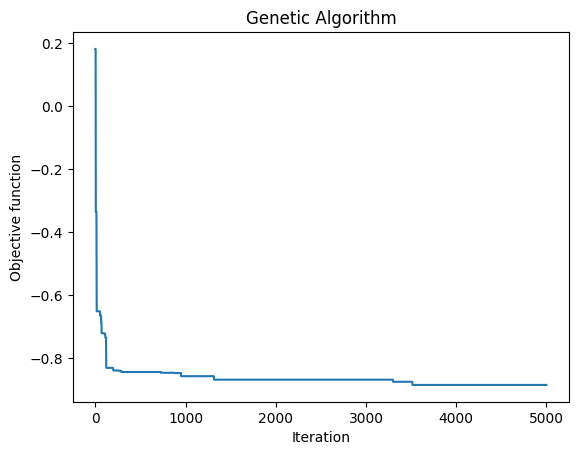

 The best solution found:                                                                           
 [10.  2.  2.  2.  5.  2.  0.  2. 14.  2.  0.  2. 19.  2.]

 Objective function:
 -0.8913837442351533


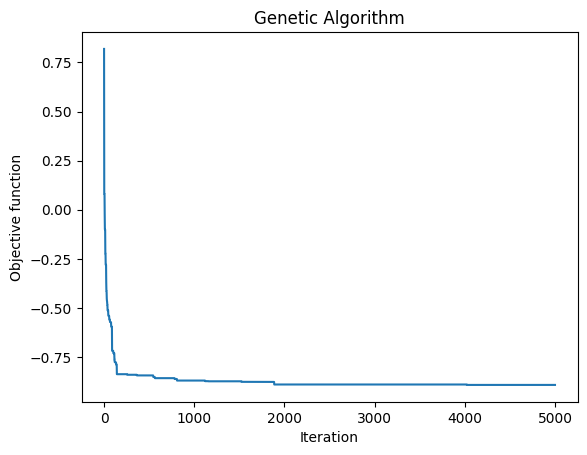

 The best solution found:                                                                           
 [15.  2.  6.  2.  8.  2.  0.  2. 13.  2.  7.  2.  2.  3.]

 Objective function:
 -0.8536193983884169


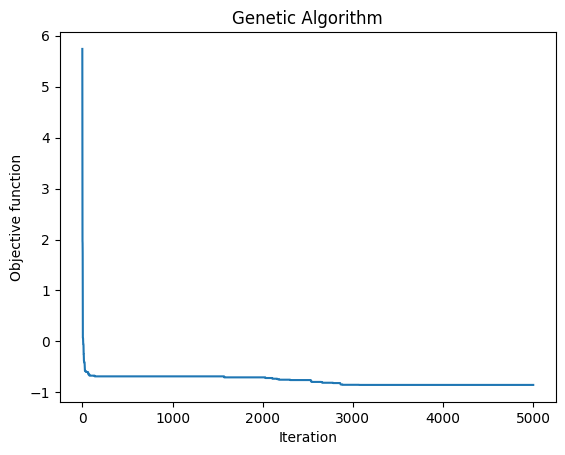

 The best solution found:                                                                           
 [12.  2.  2.  2.  2.  2.  0.  2. 13.  2.  2.  2. 20.  2.]

 Objective function:
 -0.8881905504363734


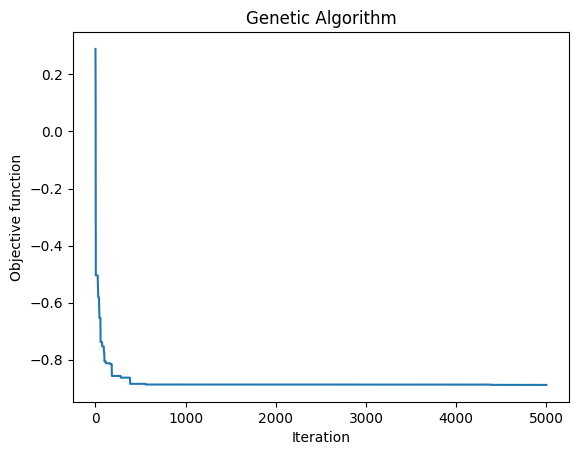

 The best solution found:                                                                           
 [13.  2.  4.  2.  6.  2.  0.  2. 12.  2.  0.  2. 18.  2.]

 Objective function:
 -0.8895241726185023


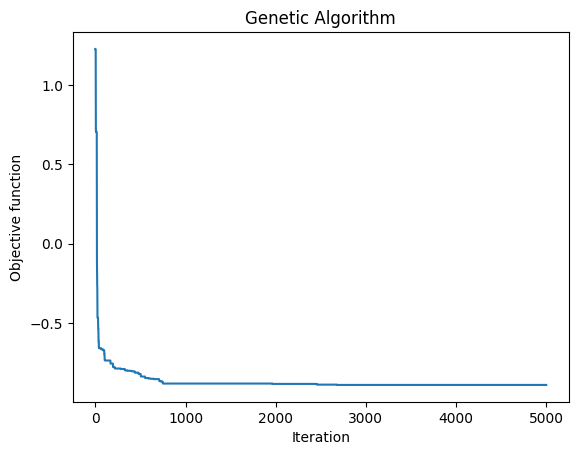

 The best solution found:                                                                           
 [10.  2.  1.  2.  3.  2.  0.  2. 14.  2.  0.  2. 19.  2.]

 Objective function:
 -0.9018999763828596


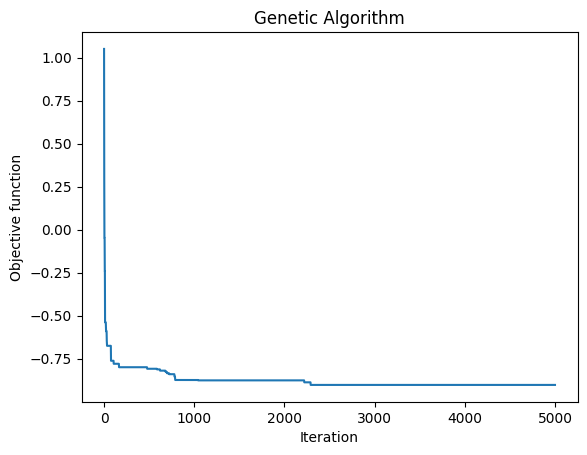

In [310]:
import numpy as np
from geneticalgorithm import geneticalgorithm as ga

varbound=np.array([[0,23], [2,5]]*7)


algorithm_param = {'max_num_iteration': 5000,\
                   'population_size':25,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

tri_history_mo = None 

for i in range(20):
    tri_model_mo=ga(function=tri_FP_MO,\
                dimension=14,\
                variable_type='int',\
                variable_boundaries=varbound,\
                algorithm_parameters=algorithm_param)

    tri_model_mo.run()

    if tri_history_mo is None:
        tri_history_mo = np.array(tri_model_mo.report)

    else:
        tri_history_mo = np.vstack((tri_history_mo,np.array(tri_model_mo.report)))

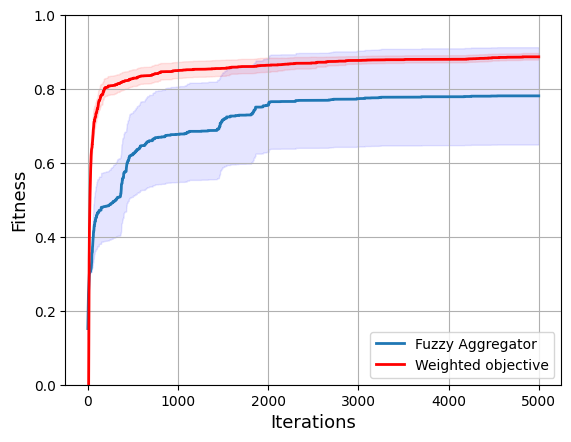

In [314]:

x_ = np.mean(-tri_history,axis=0)
ci = 1.96 * np.std(-tri_history,axis=0)/np.sqrt(tri_history.shape[0])

plt.plot(x_, linewidth=2,label='Fuzzy Aggregator')
plt.fill_between(np.arange(len(x_)),(x_-ci), (x_+ci), color='b', alpha=.1)

x_ = np.mean(-tri_history_mo,axis=0)
ci = 1.96 * np.std(-tri_history_mo,axis=0)/np.sqrt(tri_history_mo.shape[0])

plt.plot(x_, color='r', linewidth=2, label='Weighted objective')
plt.fill_between(np.arange(len(x_)),(x_-ci), (x_+ci), color='r', alpha=.1)

plt.ylim([0,1])

plt.xlabel('Iterations',fontsize=13)
plt.ylabel('Fitness',fontsize=13)
plt.legend()
plt.grid()

In [303]:
X = tri_model.output_dict['variable']

X = X.astype('int')
R = [R_VALUES[X[i]]*10**(X[i+1]) for i in range(0, X.shape[0], 2)]
Vin0 = (1 + R[0]/R[1] + R[1]/R[2])*Vin - 3*R[0]/R[1]

Vin1 = -R[4]/R[3]*Vin + 3*R[6]/R[3]*(R[4]+R[3])/(R[5]+R[6])

Vin0[Vin0 > 3] = 3 
Vin0[Vin0 < 0] = 0

Vin1[Vin1 > 3] = 3 
Vin1[Vin1 < 0] = 0

# Vinf = Vin0*R[7]/(R[7]+R[8]) + Vin1*R[8]/(R[7]+R[8])

# Vout = Vinf*(1 + R[9]/R[10])

# Vout[Vout > 3] = 3 
# Vout[Vout < 0] = 0

Vout = np.minimum(Vin0,Vin1)



In [305]:
R1 = R[4] = 6800
R2 = R[5] = 1500
R3 = R[6] = 9100
R4 = R[3] = 1800

[2700, 1000, 1100, 1800, 6800, 1500, 9100]

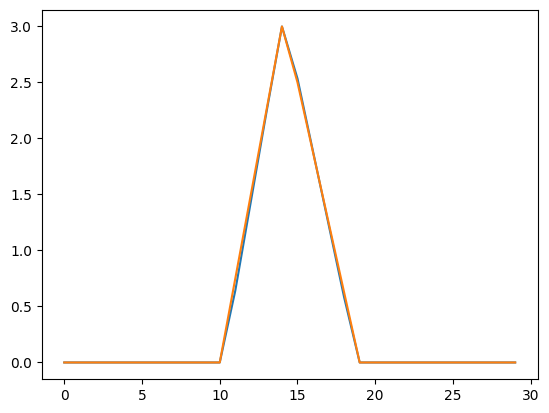

In [304]:
plt.plot(Vout)
plt.plot(Vref_tri)

 The best solution found:                                                                           
 [ 9.  2.  3.  2.  0.  2.  2.  2. 10.  2.  0.  2. 22.  2.]

 Objective function:
 -0.8261230835209606


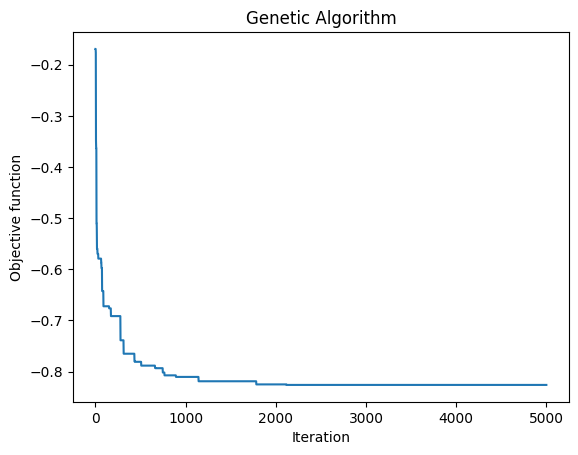

 The best solution found:                                                                           
 [16.  2.  7.  2.  2.  2.  1.  2. 11.  2.  0.  2.  2.  3.]

 Objective function:
 -0.8268534747066925


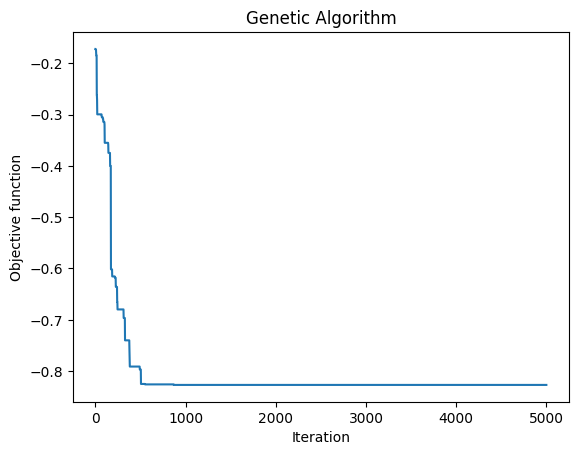

 The best solution found:                                                                           
 [11.  2.  5.  2.  2.  2.  0.  2.  9.  2.  0.  2. 22.  2.]

 Objective function:
 -0.8199640731413108


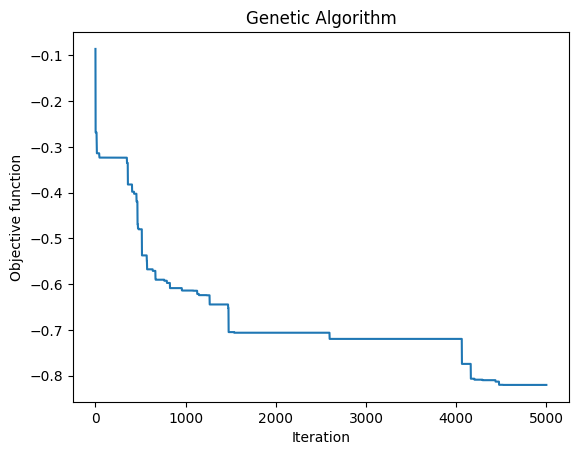

 The best solution found:                                                                           
 [ 7.  2.  2.  2.  1.  2.  0.  2.  9.  2.  0.  2. 22.  2.]

 Objective function:
 -0.8328504948063354


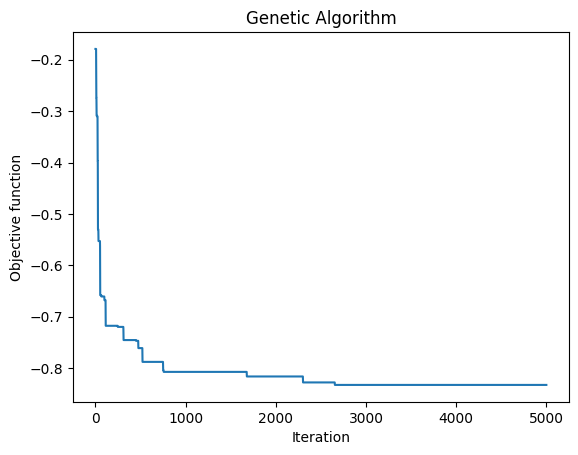

 The best solution found:                                                                           
 [16.  2.  9.  2.  6.  2.  1.  2. 11.  2.  0.  2.  1.  3.]

 Objective function:
 -0.8185559197171556


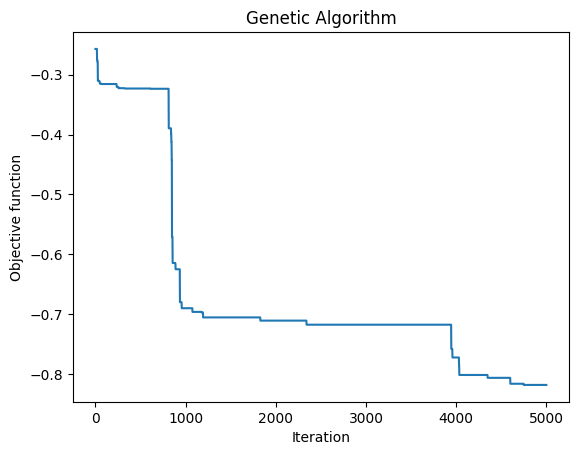

 The best solution found:                                                                           
 [ 6.  2.  1.  2.  0.  2.  0.  2.  9.  2.  0.  2. 22.  2.]

 Objective function:
 -0.8357311721222365


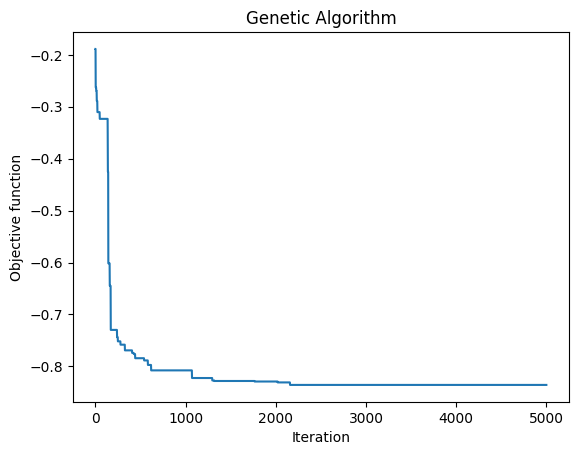

 The best solution found:                                                                           
 [ 9.  2.  3.  2.  0.  2.  1.  2. 13.  2.  0.  2.  4.  3.]

 Objective function:
 -0.853728955954078


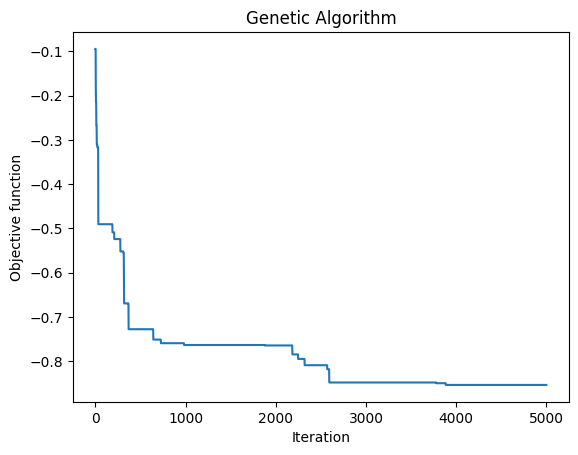

 The best solution found:                                                                           
 [ 4.  2.  0.  2.  0.  2.  0.  2.  8.  2.  0.  2. 23.  2.]

 Objective function:
 -0.8355061235049355


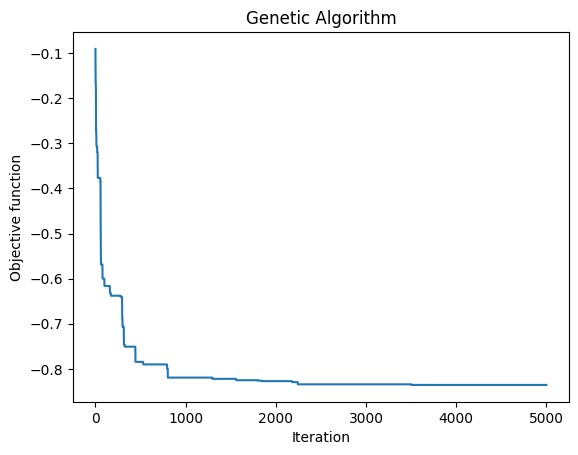

 The best solution found:                                                                           
 [14.  2.  6.  2.  2.  2.  0.  2. 11.  2.  0.  2.  3.  3.]

 Objective function:
 -0.8469588041340798


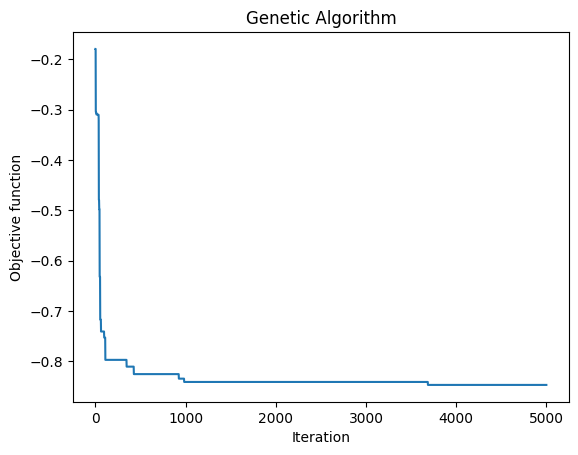

 The best solution found:                                                                           
 [21.  5. 18.  5. 20.  5. 14.  3.  6.  4. 21.  2. 14.  4.]

 Objective function:
 -0.3236746995240104


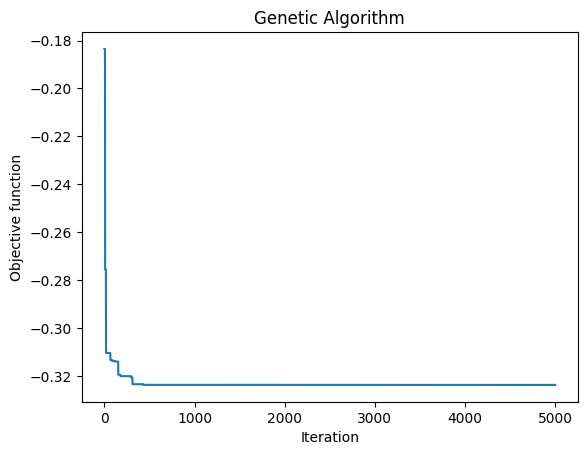

 The best solution found:                                                                           
 [15.  4.  2.  4. 16.  3.  1.  2. 16.  2. 10.  3.  3.  5.]

 Objective function:
 -0.32353921014575593


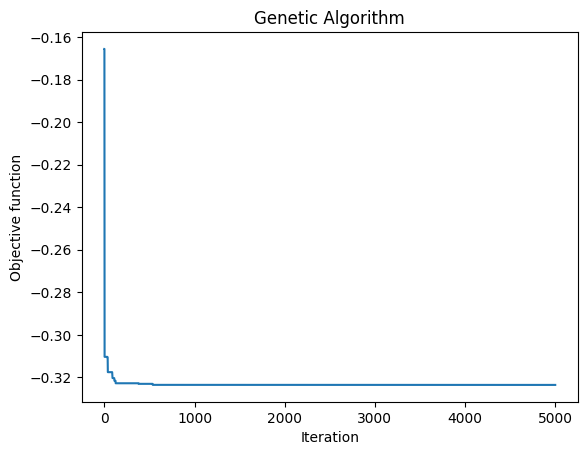

 The best solution found:                                                                           
 [11.  2.  4.  2.  1.  2.  4.  2. 15.  2.  0.  2.  2.  3.]

 Objective function:
 -0.834523390101941


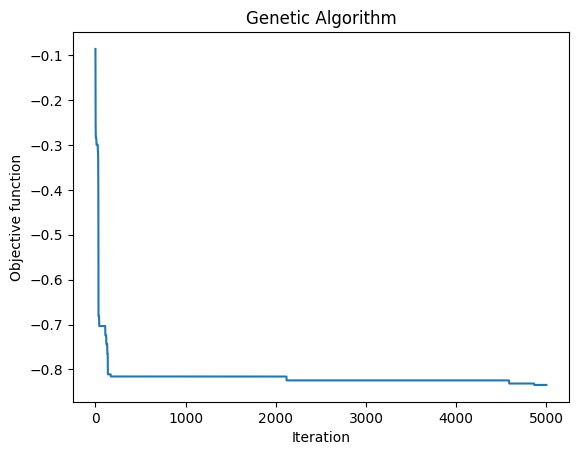

 The best solution found:                                                                           
 [ 8.  2.  2.  2.  0.  2.  1.  2. 13.  2.  0.  2.  4.  3.]

 Objective function:
 -0.8623098745226068


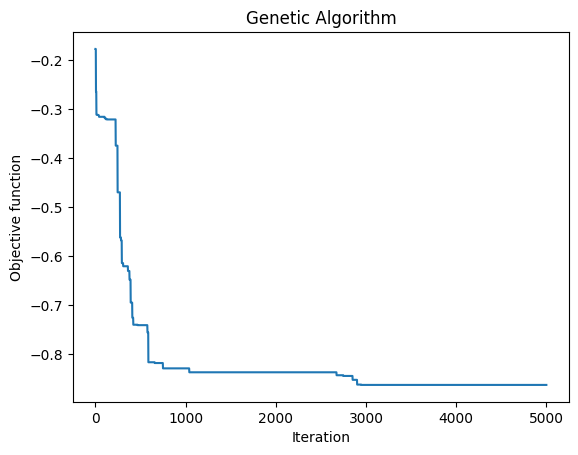

 The best solution found:                                                                           
 [14.  2.  7.  2.  4.  2.  1.  2. 12.  2.  0.  2.  3.  3.]

 Objective function:
 -0.8349490121532354


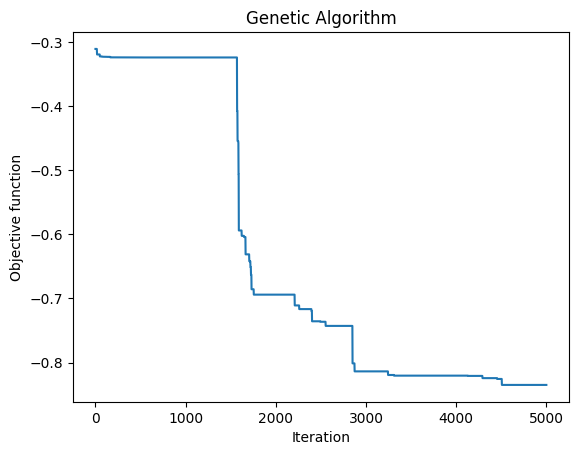

 The best solution found:                                                                           
 [ 6.  2.  1.  2.  0.  2.  2.  2. 14.  2.  0.  2.  4.  3.]

 Objective function:
 -0.8555411595936065


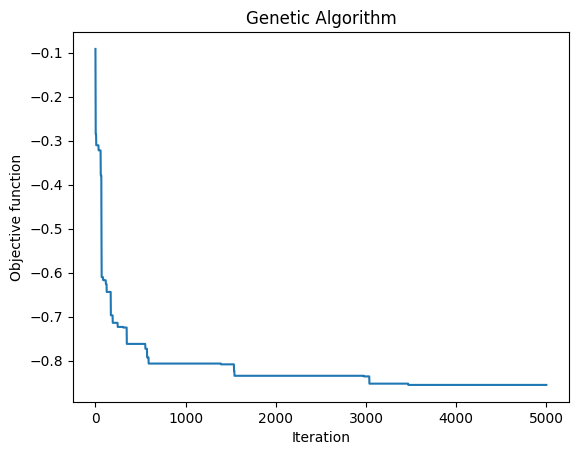

 The best solution found:                                                                           
 [ 8.  2.  2.  2.  0.  2.  0.  2. 11.  2.  0.  2.  4.  3.]

 Objective function:
 -0.8616073198023837


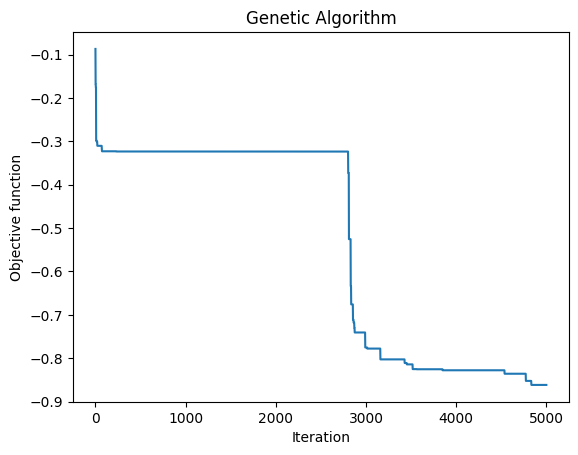

 The best solution found:                                                                           
 [ 4.  2.  1.  2.  2.  2.  0.  2.  9.  2.  0.  2. 23.  2.]

 Objective function:
 -0.8311892547998121


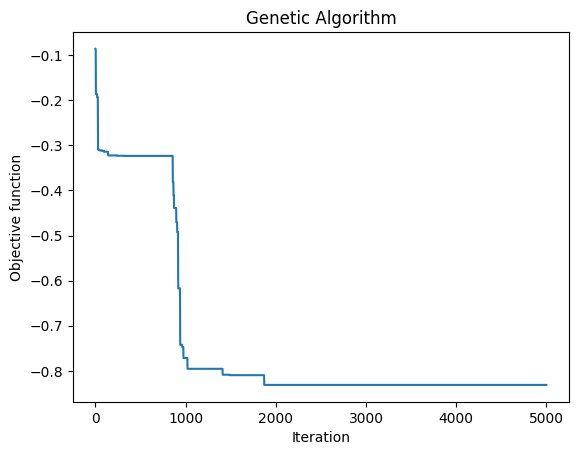

 The best solution found:                                                                           
 [21.  4. 17.  4. 16.  4. 17.  4.  8.  5. 21.  2. 18.  4.]

 Objective function:
 -0.3236747135449855


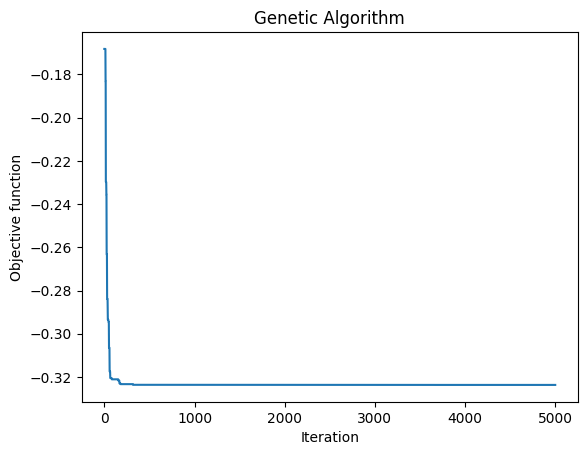

 The best solution found:                                                                           
 [11.  2.  4.  2.  1.  2.  0.  2. 11.  2.  0.  2.  4.  3.]

 Objective function:
 -0.8566203037603425


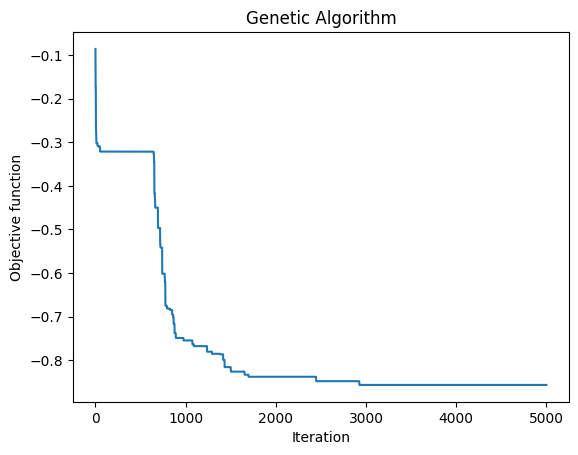

 The best solution found:                                                                           
 [11.  2.  4.  2.  1.  2.  2.  2. 12.  2.  0.  2.  2.  3.]

 Objective function:
 -0.8328817497933779


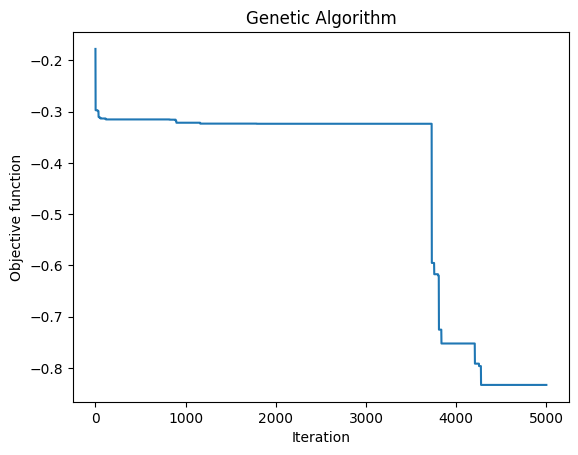

In [316]:
import numpy as np
from geneticalgorithm import geneticalgorithm as ga

varbound=np.array([[0,23], [2,5]]*7)


algorithm_param = {'max_num_iteration': 5000,\
                   'population_size':50,\
                   'mutation_probability':0.15,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

trap_history = None 

for i in range(20):
    trap_model=ga(function=trap_FP,\
                dimension=14,\
                variable_type='int',\
                variable_boundaries=varbound,\
                algorithm_parameters=algorithm_param)

    trap_model.run()

    if trap_history is None:
        trap_history = np.array(trap_model.report)
    else:
        trap_history = np.vstack((trap_history,np.array(trap_model.report)))

 The best solution found:                                                                           
 [12.  2.  4.  2.  0.  2.  0.  2. 11.  2.  0.  2.  3.  3.]

 Objective function:
 -0.8026100097174886


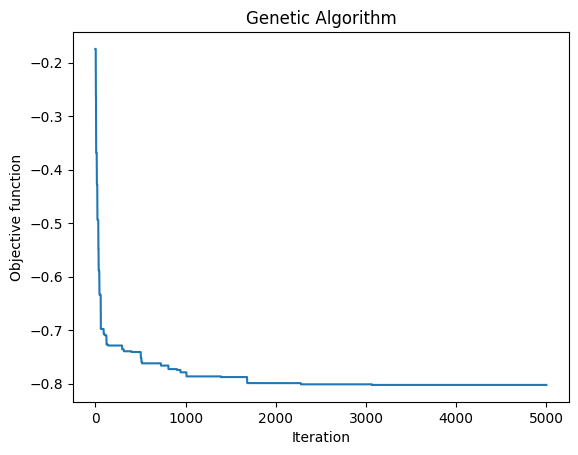

 The best solution found:                                                                           
 [10.  2.  4.  2.  2.  2.  2.  2. 14.  2.  0.  2.  4.  3.]

 Objective function:
 -0.7963245881130947


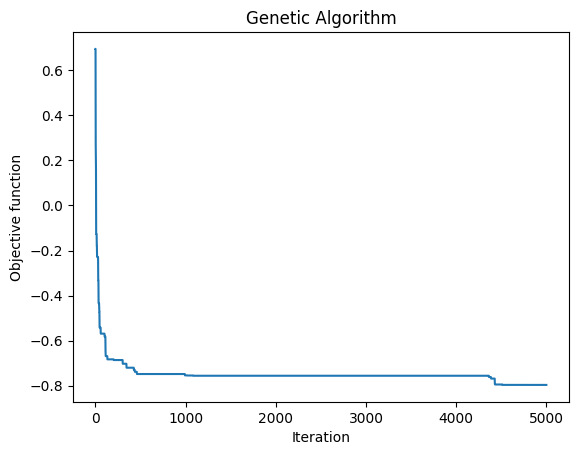

 The best solution found:                                                                           
 [ 7.  2.  2.  2.  1.  2.  0.  2. 10.  2.  0.  2.  2.  3.]

 Objective function:
 -0.8034627822920598


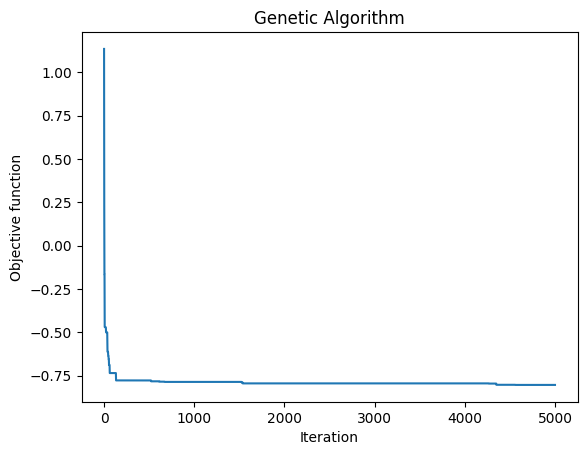

 The best solution found:                                                                           
 [ 6.  2.  1.  2.  0.  2.  0.  2. 11.  2.  0.  2.  3.  3.]

 Objective function:
 -0.8064646711659371


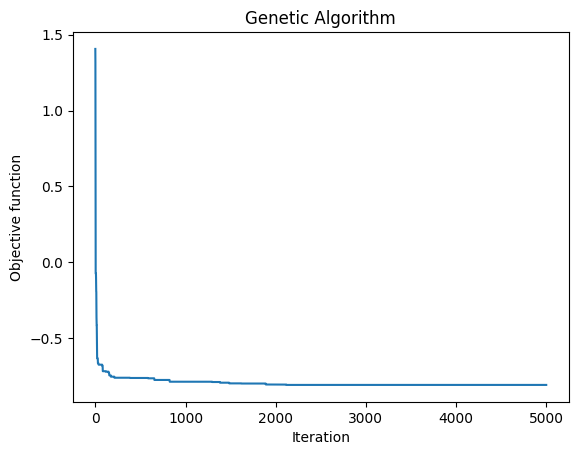

 The best solution found:                                                                           
 [13.  2.  6.  2.  3.  2.  0.  2. 12.  2.  0.  2.  5.  3.]

 Objective function:
 -0.7965005855057602


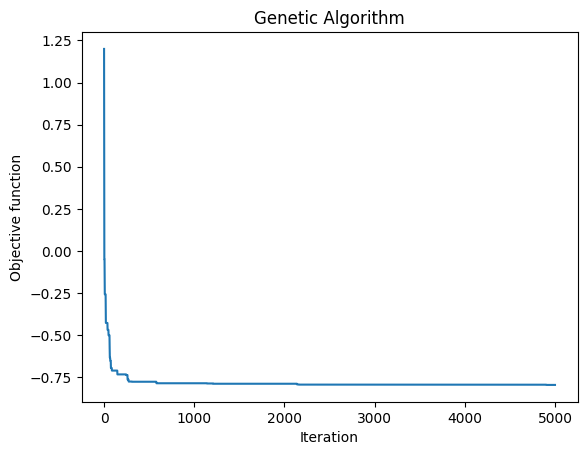

 The best solution found:                                                                           
 [14.  2.  7.  2.  4.  2.  0.  2. 13.  2.  0.  2.  7.  3.]

 Objective function:
 -0.7860610870341072


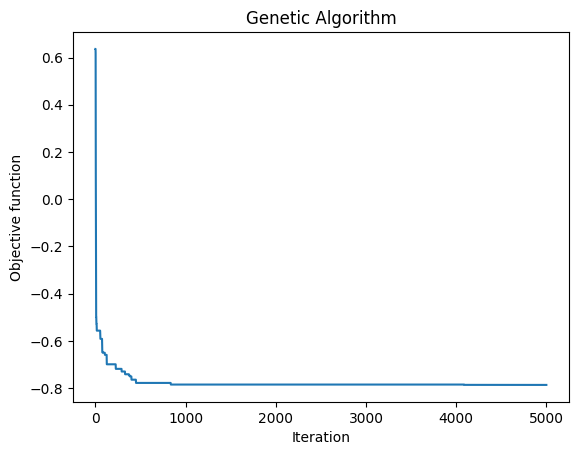

 The best solution found:                                                                           
 [ 7.  2.  2.  2.  1.  2.  3.  2. 13.  2.  0.  2.  2.  3.]

 Objective function:
 -0.79865622271615


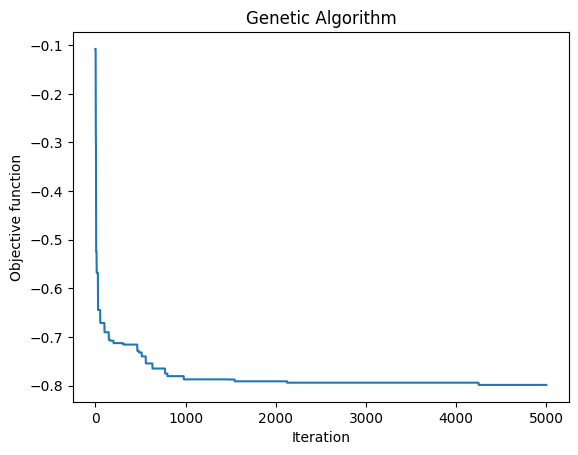

 The best solution found:                                                                           
 [ 9.  2.  4.  2.  4.  2.  0.  2.  9.  2.  0.  2. 23.  2.]

 Objective function:
 -0.7871090225433361


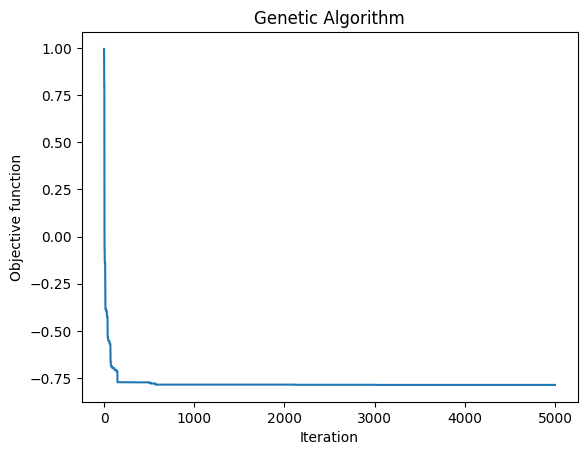

 The best solution found:                                                                           
 [10.  2.  4.  2.  2.  2.  1.  2. 12.  2.  0.  2.  3.  3.]

 Objective function:
 -0.7998068654448778


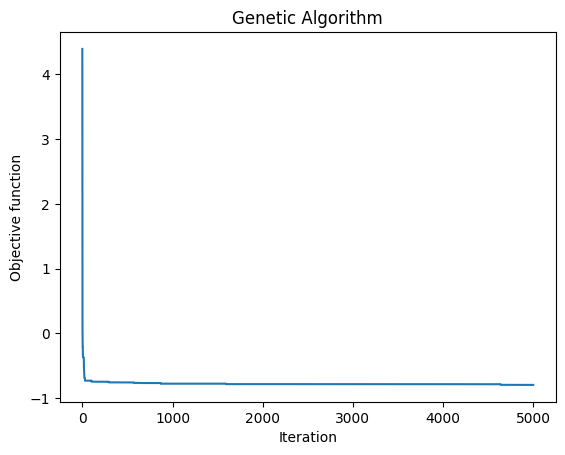

 The best solution found:                                                                           
 [12.  2.  5.  2.  2.  2.  0.  2. 12.  2.  0.  2.  5.  3.]

 Objective function:
 -0.7974994046131105


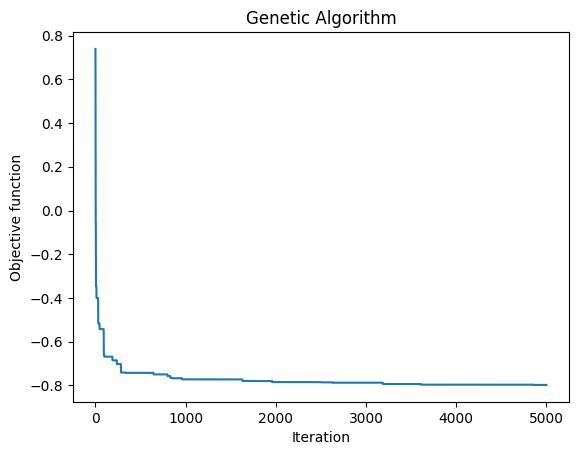

 The best solution found:                                                                           
 [10.  2.  4.  2.  2.  2.  0.  2. 11.  2.  0.  2.  3.  3.]

 Objective function:
 -0.8018068654448778


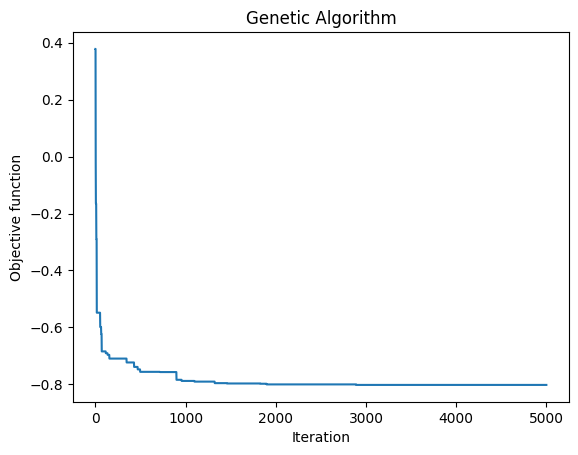

 The best solution found:                                                                           
 [ 9.  2.  3.  2.  0.  2.  0.  2. 12.  2.  0.  2.  5.  3.]

 Objective function:
 -0.8027826079493932


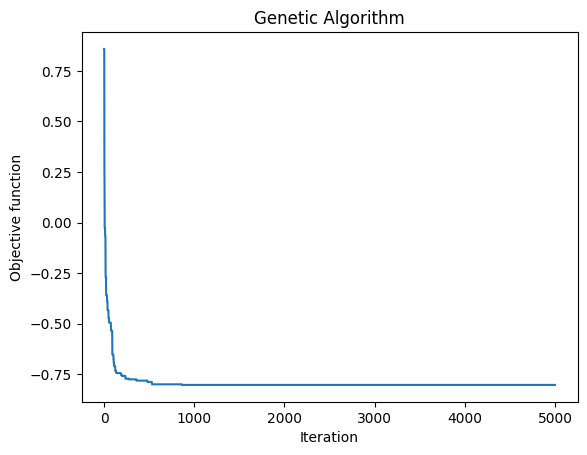

 The best solution found:                                                                           
 [ 7.  2.  3.  2.  3.  2.  0.  2. 11.  2.  0.  2.  3.  3.]

 Objective function:
 -0.7991117363412489


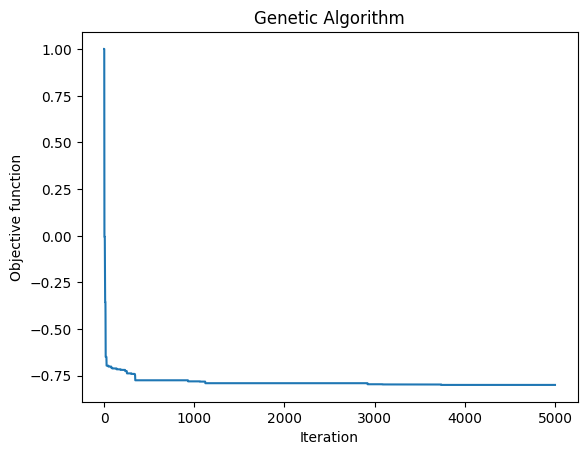

 The best solution found:                                                                           
 [ 8.  2.  2.  2.  0.  2.  0.  2. 11.  2.  0.  2.  3.  3.]

 Objective function:
 -0.8078720440709196


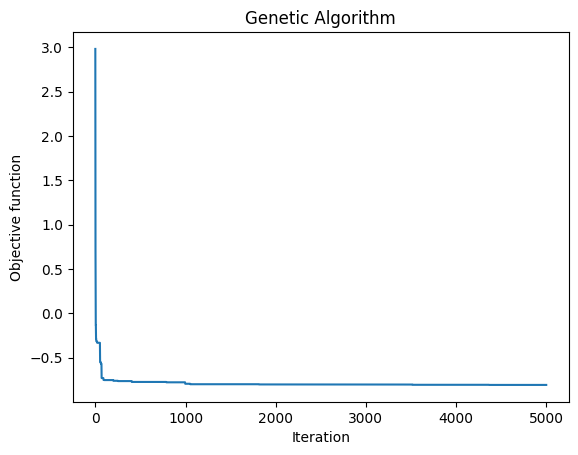

 The best solution found:                                                                           
 [ 8.  2.  2.  2.  0.  2.  3.  2. 13.  2.  0.  2.  2.  3.]

 Objective function:
 -0.801264979235375


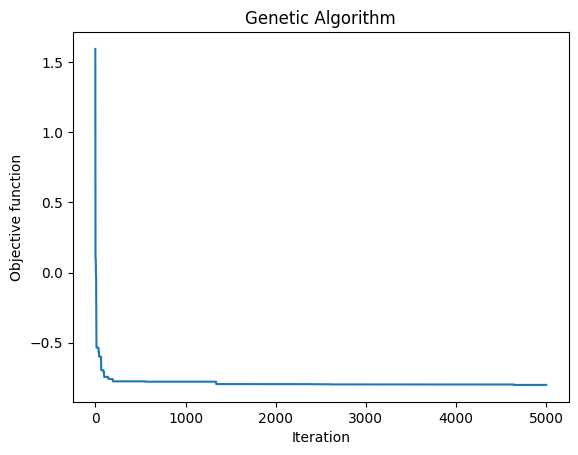

 The best solution found:                                                                           
 [12.  2.  5.  2.  1.  2.  0.  2. 10.  2.  0.  2.  2.  3.]

 Objective function:
 -0.798339658153437


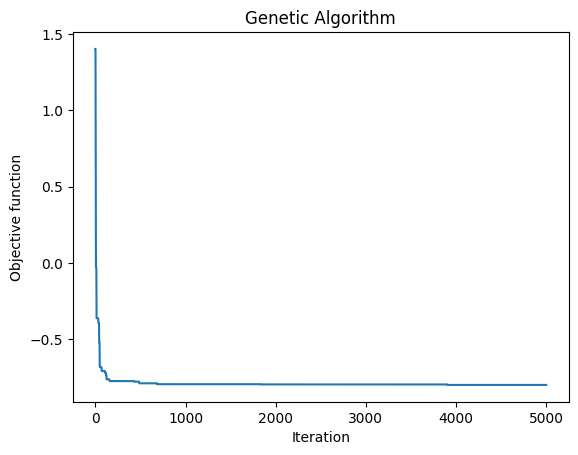

 The best solution found:                                                                           
 [ 9.  2.  3.  2.  0.  2.  1.  2. 12.  2.  0.  2.  3.  3.]

 Objective function:
 -0.802777041593085


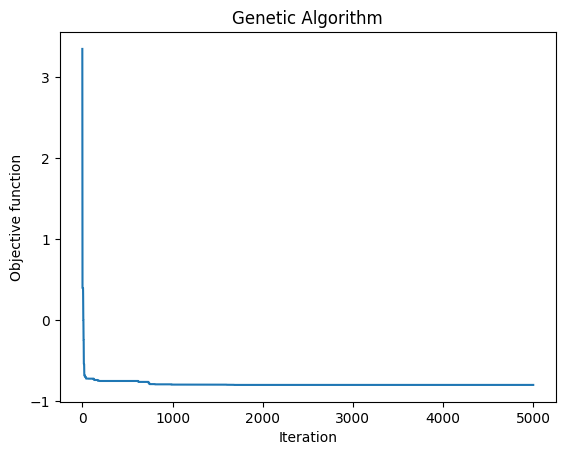

 The best solution found:                                                                           
 [ 4.  2.  0.  2.  0.  2.  0.  2. 11.  2.  0.  2.  3.  3.]

 Objective function:
 -0.803486911888595


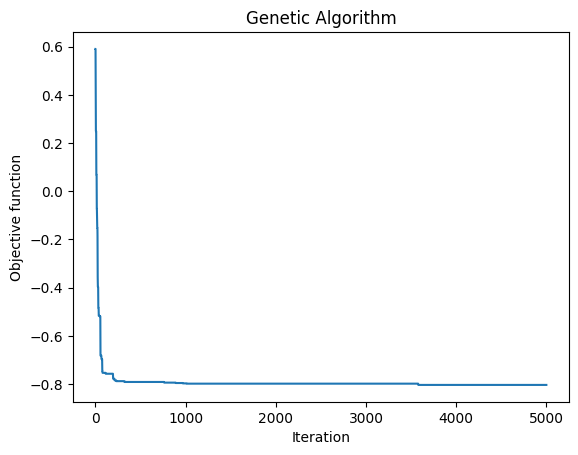

 The best solution found:                                                                           
 [13.  2.  6.  2.  3.  2.  0.  2. 11.  2.  0.  2.  3.  3.]

 Objective function:
 -0.7978066725966894


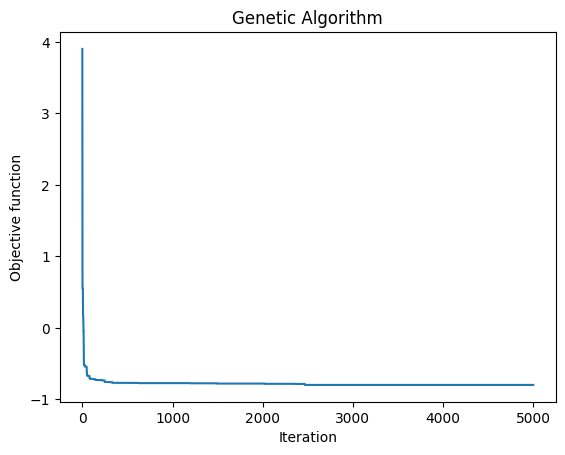

 The best solution found:                                                                           
 [ 9.  2.  3.  2.  0.  2.  3.  2. 14.  2.  0.  2.  3.  3.]

 Objective function:
 -0.798777041593085


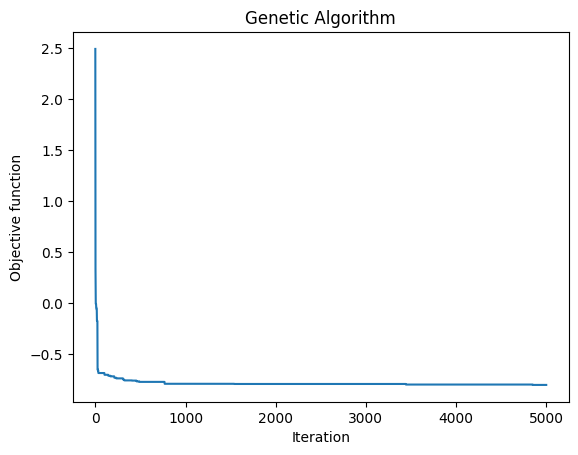

In [317]:
algorithm_param = {'max_num_iteration': 5000,\
                   'population_size':50,\
                   'mutation_probability':0.15,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

trap_history_mo = None 

for i in range(20):
    trap_model_mo=ga(function=trap_FP_MO,\
                dimension=14,\
                variable_type='int',\
                variable_boundaries=varbound,\
                algorithm_parameters=algorithm_param)

    trap_model_mo.run()

    if trap_history_mo is None:
        trap_history_mo = np.array(trap_model_mo.report)
    else:
        trap_history_mo = np.vstack((trap_history_mo,np.array(trap_model_mo.report)))

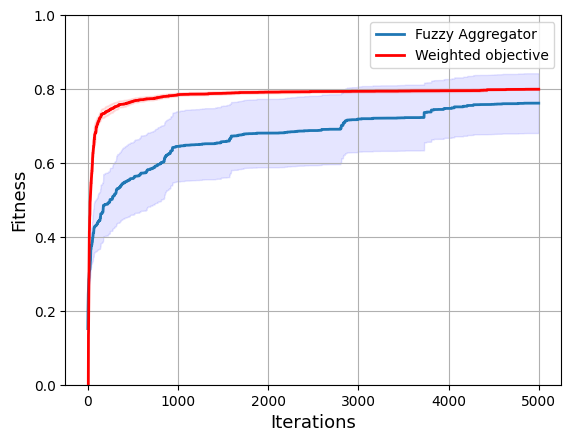

In [318]:

x_ = np.mean(-trap_history,axis=0)
ci = 1.96 * np.std(-trap_history,axis=0)/np.sqrt(trap_history.shape[0])

plt.plot(x_, linewidth=2,label='Fuzzy Aggregator')
plt.fill_between(np.arange(len(x_)),(x_-ci), (x_+ci), color='b', alpha=.1)

x_ = np.mean(-trap_history_mo,axis=0)
ci = 1.96 * np.std(-trap_history_mo,axis=0)/np.sqrt(trap_history_mo.shape[0])

plt.plot(x_, color='r', linewidth=2, label='Weighted objective')
plt.fill_between(np.arange(len(x_)),(x_-ci), (x_+ci), color='r', alpha=.1)

plt.ylim([0,1])

plt.xlabel('Iterations',fontsize=13)
plt.ylabel('Fitness',fontsize=13)
plt.legend()
plt.grid()

In [212]:
X = model.output_dict['variable']

X = X.astype('int')
R = [R_VALUES[X[i]]*10**(X[i+1]) for i in range(0, X.shape[0], 2)]
Vin0 = (1 + R[0]/R[1] + R[1]/R[2])*Vin - 3*R[0]/R[1]

Vin1 = -R[4]/R[3]*Vin + 3*R[6]/R[3]*(R[4]+R[3])/(R[5]+R[6])

Vin0[Vin0 > 3] = 3 
Vin0[Vin0 < 0] = 0

Vin1[Vin1 > 3] = 3 
Vin1[Vin1 < 0] = 0

# Vinf = Vin0*R[7]/(R[7]+R[8]) + Vin1*R[8]/(R[7]+R[8])

# Vout = Vinf*(1 + R[9]/R[10])

# Vout[Vout > 3] = 3 
# Vout[Vout < 0] = 0

Vout = np.minimum(Vin0,Vin1)



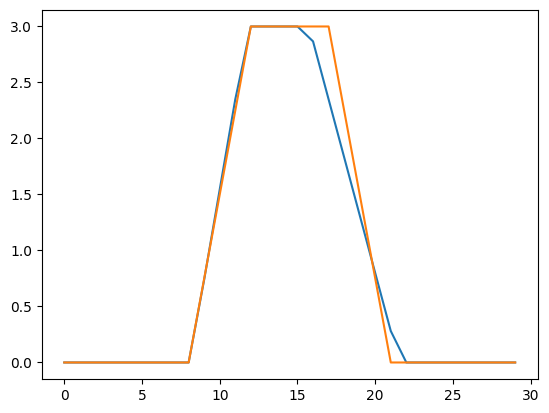

In [213]:
plt.plot(Vout)
plt.plot(Vref_trap)